In [1]:
#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go


sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from receptive_field import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder

possible models to visualizer are:
['mnist_resize', 'alexnet_old.tar.gz', 'mnist_old', '.keep', 'mnist', 'old', 'alexnet10', 'letter_mixed_not_trained', '.DS_Store', 'alexnet_lucent', 'mnist.tgz', 'alexnet', 'letter_mixed', 'googlenet10_test', '._.DS_Store', 'alexnet.tar.gz']

You've chosen to visualize alexnet


In [2]:
#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None
params['deepviz_image_size'] = prep_model_params.deepviz_image_size

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously

 
#aesthetic 

params['node_size'] = 12
params['edge_size'] = 1
params['max_node_inputs'] = 10    #there is a dropdown showing the top weighted edge inputs to nodes, how many maps in dropdown?
params['layer_colors'] = ['rgba(31,119,180,', 
                          'rgba(255,127,14,',
                          'rgba(44,160,44,', 
                          'rgba(214,39,40,',
                          'rgba(39, 208, 214,', 
                          'rgba(242, 250, 17,',
                          'rgba(196, 94, 255,',
                          'rgba(193, 245, 5,',
                          'rgba(245, 85, 5,',
                          'rgba(5, 165, 245,',
                          'rgba(245, 5, 105,',
                          'rgba(218, 232, 23,',
                          'rgba(148, 23, 232,',
                          'rgba(23, 232, 166,',]




#GUI parameters initialization (these parameters can be set in the GUI, but what values should they be initialized to?)
target_category = 'overall'     #category of images edges and nodes are weighted based on (which subgraph) 
rank_type = 'actxgrad'       #weighting criterion (actxgrad, act, grad, or weight)
projection = 'MDS'           #how nodes within a layer are projected into the 2d plane (MDS or Grid)
edge_threshold = [.7,1]     #what range do edge ranks need to be in to be visualized


#### DONT EDIT BELOW initializations

figure_init = go.Figure()
figure_init.add_trace(go.Scatter(
            x=[],
            y=[]))
figure_init.update_layout(xaxis=dict(visible=False),
                  yaxis=dict(visible=False),
                  annotations = [dict(text="No Inputs",
                                      xref="paper",
                                      yref="paper",
                                      showarrow=False,
                                      font=dict(size=28))]
                 )

params['max_edge_weight'] = 1  #for the edge threshold slider, this dynamically adjusted its max value to max edge rank
                     #before there were multiple rank criterions, which made things confusing
                     #so well just fix it to 1 for now

In [3]:
#load Model

model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    

print('loaded model:')
print(prep_model_params.model)
        
#del prep_model_params.model
model = prep_model_params.model
if params['cuda']:
    model.cuda()
model = model.eval()


loaded model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096

In [4]:
#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'


print('model has categories:')
print(params['categories'])

loading misc graph data
model has categories:
['overall', 'Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_elephant', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'American_chameleon', 'American_coot', 'American_egret', 'American_lobster', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'CD_player', 'Cardigan_corgi', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Crock_Pot', 'Dandie_Dinmont', 'Doberman', 'Dungeness_crab', 'Dutch_oven', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd

In [5]:
#load nodes df
print('loading nodes rank data')
target_node = 'loss'

categories_nodes_df = pd.read_csv('prepped_models/%s/ranks/categories_nodes_ranks_2.csv'%prepped_model_folder)
target_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]

target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=False)

weight_nodes_df = pd.read_csv('prepped_models/%s/ranks/weight_nodes_ranks.csv'%prepped_model_folder)

weight_nodes_df = minmax_normalize_ranks_df(weight_nodes_df,params,weight=True)

node_colors,node_weights = gen_node_colors(target_nodes_df,rank_type,params) 

#load node positions
print('loading node position data')
all_node_positions = pickle.load(open('./prepped_models/%s/node_positions.pkl'%prepped_model_folder,'rb'))

if projection == 'MDS':
    node_positions = all_node_positions[projection][rank_type]
else:
    node_positions = all_node_positions[projection]



loading nodes rank data


/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/visualizer_scripts/visualizer_helper_functions.py:146: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



loading node position data


In [6]:
len(params['layer_nodes'][0][1])
params['imgnode_names']
print(params['layer_nodes'][1][1])

[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255]


In [7]:
#load edges
print('loading edge data')

categories_edges_df = None
if os.path.exists('prepped_models/%s/edge_ranks.csv'%prepped_model_folder):
    categories_edges_df = pd.read_csv('prepped_models/%s/ranks/categories_edges_ranks.csv'%prepped_model_folder)   #load edges

if categories_edges_df is not None:
    #overall_edges_df = categories_edges_df.loc[categories_edges_df['category']=='overall']
    target_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
else:
    #overall_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','overall_edges_rank.pt'))
    target_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))

target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=False)

weight_edges_df = pd.read_csv('prepped_models/%s/ranks/weight_edges_ranks.csv'%prepped_model_folder)
  
weight_edges_df = minmax_normalize_ranks_df(weight_edges_df,params,weight=True)    
    
edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)
 
    
num_edges = len(target_edges_df)
edges_df_columns = list(target_edges_df.columns)

edge_positions, edge_colors, edge_widths, edge_weights, edge_names, max_edge_width_indices = gen_edge_graphdata(edges_thresholded_df, node_positions, rank_type, target_category,params)

loading edge data


In [8]:
#Load Edge Kernels
print('loading convolutional kernels')
kernels = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)

loading convolutional kernels


In [9]:
#Input Image names
params['input_image_directory'] = prep_model_params.input_img_path+'/'
params['input_image_list'] = os.listdir(params['input_image_directory'])
params['input_image_list'].sort()
input_image_name = params['input_image_list'][0]

In [10]:
receptive_fields = None
if os.path.exists('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder):
    receptive_fields = pickle.load(open('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder,'rb'))
    
input_image_size = 224   #got to figure out a way not to hard-code this
receptive_fields

OrderedDict([('features_-1',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 224, 224])])),
             ('features_0',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_1',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 64, 55, 55]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_2',
              OrderedDict([('j', 8.0),
                           ('r', 19.0),
                           ('start', 7.5),
                           

In [11]:
#Format Node Feature Maps
print('loading activation maps')

all_activations = {'nodes':{},'edges_in':{},'edges_out':{}}
if os.path.exists('prepped_models/%s/input_img_activations.pt'%prepped_model_folder):
    all_activations = torch.load('prepped_models/%s/input_img_activations.pt'%prepped_model_folder)


loading activation maps


In [12]:
#hidden state, stores python values within the html itself
state = {'projection':projection,'rank_type':rank_type,'edge_positions':edge_positions,'edge_colors': edge_colors, 'edge_widths':edge_widths,'edge_names':edge_names,
         'edge_threshold':edge_threshold,'edge_weights':edge_weights,'max_edge_width_indices':max_edge_width_indices,
         'node_positions':node_positions,'node_colors':node_colors,'node_weights':node_weights,'target_category':target_category,'target_node':'loss',
         'node_select_history':['0'],'edge_select_history':[edge_names[0][0]],'last_trigger':None,'input_image_name':input_image_name,
         'imgnode_positions':params['imgnode_positions'],'imgnode_colors':params['imgnode_colors'],'imgnode_names':params['imgnode_names']}


In [13]:
#App Component Layouts
axis=dict(showbackground=False,
          showspikes=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          #range=[0,0],
          title=''
          )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.00, y=-1.25, z=1.25)
)


network_graph_layout = go.Layout(
         #title="%s through Prunned Cifar10 CNN"%target_category,
         #title = target_category,
         #width=1000,
         clickmode = 'event+select',
         transition = {'duration': 20},
         height=500,
         #showlegend=False,
         margin = dict(l=20, r=20, t=20, b=20),
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
             aspectmode ="manual", 
             aspectratio = dict(x=1, y=0.5, z=0.5) #adjusting this stretches the network layer-to-layer
         ),
         scene_camera = camera,
         uirevision =  True   
         #hovermode='closest',
   )


input_image_layout = go.Layout(#width=200, 
                      #height=200,
                      uirevision = True,
                      margin=dict(
                        l=12,
                        r=1,
                        b=12,
                        t=1,
                        pad=10
                        ),
                        paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)',
                        xaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False),
                        yaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False))


node_actmap_layout = go.Layout(
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


edge_inmap_layout = go.Layout(
    #title = 'edge input map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


edge_outmap_layout = go.Layout(
    #title = 'edge output map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    #width=180,
    #height=120,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


In [14]:
#Generate Network Graph
combined_traces = gen_networkgraph_traces(state,params)
network_graph_fig=go.Figure(data=combined_traces, layout=network_graph_layout)

building graph from browser "state"


In [15]:
#Dash App Setup
print('setting up dash app')

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import os

import json

from dash.dependencies import Input, Output, State

from plotly.subplots import make_subplots

from flask_caching import Cache

#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(external_stylesheets = external_stylesheets)



if not os.path.exists(full_prepped_model_folder+'/cache/'):
    os.mkdir(full_prepped_model_folder+'/cache/')
CACHE_CONFIG = {
    # try 'filesystem' if you don't want to setup redis
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': full_prepped_model_folder+'/cache/'}
cache = Cache()
cache.init_app(app.server, config=CACHE_CONFIG)
    


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


theme =  {
    'dark': True,
    'detail': '#007439',
    'primary': '#00EA64',
    'secondary': '#6E6E6E',
}


app.layout = html.Div([
        html.Div(
            children = [
                
            html.Div(
                #Left side control panel
                children = [
                 html.Label('Input'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Input(id='input-category',value=state['target_category']),
                html.Br(),
                html.Br(),
                html.Label('Output'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Dropdown(
                    id='target-node',
                    options=[
                    {'label': i, 'value': i} for i in ['loss']+[str(node) for node in list(range(params['num_nodes']))]
                    ],
                    value=state['target_node']),
                 html.Br(),
                 html.Label('Subgraph Criterion'),
                 dcc.Dropdown(
                    id='subgraph-criterion',
                    options=[
                        {'label': 'Activations*Grads', 'value': 'actxgrad'},
                        {'label': 'Activations', 'value': 'act'},
                        {'label': 'Gradients', 'value': 'grad'},
                        {'label': 'Weights', 'value': 'weight'}
                    ],
                    value='actxgrad'
                    ),
                 html.Br(),   
                 html.Label('Layer Projection'),
                 dcc.Dropdown(
                    id = 'layer-projection',
                    options=[
                        {'label': 'MDS', 'value': 'MDS'},
                        {'label': 'Grid', 'value': 'Grid'},
                        #{'label': 'SOM', 'value': 'SOM'}
                    ],
                    value='MDS'
                    ),

                html.Br(),
                html.Label('Edge Thresholds'),
                    dcc.RangeSlider(
                        id='edge-thresh-slider',
                        min=0,
                        max=np.ceil(params['max_edge_weight']*10)/10,
                        step=0.001,
                        marks={i/10: str(i/10) for i in range(0,int(np.ceil(params['max_edge_weight']*10))+1,int(round(np.ceil(params['max_edge_weight']*10)/5)))},
                        value=[.7,np.ceil(params['max_edge_weight']*10)/10],
                    ),

                ], className="two columns",
                ),
                
            html.Div([
                dcc.Graph(
                    id='network-graph',
                    figure=network_graph_fig
                )
                ], className= 'ten columns'
                ),
            ], className="row"
        ),


                
        html.Div([
            html.Div([
            html.Label('Input Image'),
            dcc.Dropdown(id="dynamic-input-image-dropdown",value=params['input_image_list'][0]),
            #dcc.Dropdown(
            #    id='input-image-dropdown',
            #    options=[{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')],
            #    value=input_image_name
            #),
            html.Br(),
            dcc.Graph(
                id='img-actmap-graph',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=image2heatmap(params['input_image_directory']+input_image_name,input_image_layout),
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "two columns"),

            html.Div([
            html.Label('Node'),
            dcc.Dropdown(
                id='node-actmap-dropdown',
                options=[{'label': str(j), 'value': str(j)} for j in params['imgnode_names']]+[{'label': str(i), 'value': str(i)} for i in range(params['num_nodes'])],
                value='0'
            ),
            html.Br(),
            dcc.Graph(
                id='node-actmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            dcc.Checklist(
                id = 'relu-checkbox',
                options = [{'label':'relu','value':'relu'}],
                value = []
                
            ),
            html.Div(id='node-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='node-deepviz-image',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "three columns"),
            
            html.Div([
            html.Label('Node Inputs'),
            html.Br(),
            html.Div(dcc.Graph(
                id='node-inputs-graph',
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),style={'overflowY': 'scroll', 'height': 500})
            ], className = "three columns"),

            html.Div([
            html.Label('Edge'),    
            dcc.Input(
                id='edge-actmaps-input',value=state['edge_names'][0][0], type='text'),
            #html.Button(id='edge-kernel-button',n_clicks=0, children='Submit'),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='edge-kernel-graph',
                style={
               'width': '14vw',
               'height':'10vw'
                },
                figure=go.Figure(data=go.Heatmap(
                                    z = edgename_2_edge_figures(state['edge_names'][0][0], input_image_name, kernels, None,params)[0]),
                                 layout=kernel_layout
                                ),
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            dcc.Graph(
               id='edge-deepviz-image',
               style={
              'width': '14vw',
              'height':'14vw'
               },
               figure=figure_init,
               config={
                       'displayModeBar': False
                       }
            )
            ], className = "two columns"),


            html.Div([
            html.Label('Edge Input'),
            html.Br(),
            dcc.Graph(
                id='edge-inmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgein-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            html.Label('Edge Output'),
            html.Br(),
            dcc.Graph(
                id='edge-outmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgeout-sum', style={'whiteSpace': 'pre-line'}),

            ], className = "two columns")


         ], className= 'row'
         ),
                
                
        html.Div([
            html.Div([
                dcc.Markdown("""
                    **Hover Data**

                    Mouse over values in the graph.
                """),
                html.Pre(id='hover-data', style=styles['pre'])
            ], className='two columns'),

            html.Div([
                dcc.Markdown("""
                    **Click Data**

                    Click on points in the graph.
                """),
                html.Pre(id='click-data', style=styles['pre']),
            ], className='two columns'),

            html.Div([
                dcc.Markdown("""
                    **Selection Data**

                    Choose the lasso or rectangle tool in the graph's menu
                    bar and then select points in the graph.

                    Note that if `layout.clickmode = 'event+select'`, selection data also 
                    accumulates (or un-accumulates) selected data if you hold down the shift
                    button while clicking.
                """),
                html.Pre(id='selected-data', style=styles['pre']),
            ], className='two columns'),

#                 html.Div([
#                     dcc.Markdown("""
#                         **Zoom and Relayout Data**

#                         Click and drag on the graph to zoom or click on the zoom
#                         buttons in the graph's menu bar.
#                         Clicking on legend items will also fire
#                         this event.
#                     """),
#                     html.Pre(id='relayout-data', style=styles['pre']),
#                 ], className='two columns')
                
            html.Div([
                dcc.Markdown("""
                    **Figure Data**

                    Figure json info.
                """),
                html.Pre(id='figure-data', style=styles['pre']),
            ], className='four columns')

        ], className= 'row'
        ),

    #hidden divs for storing intermediate values     
    # The memory store reverts to the default on every page refresh
    dcc.Store(id='memory',data=state),
    # The local store will take the initial data
    # only the first time the page is loaded
    # and keep it until it is cleared.
    #dcc.Store(id='local', storage_type='local'),
    # Same as the local store but will lose the data
    # when the browser/tab closes.
    #dcc.Store(id='session', storage_type='session',data=state),
    

    # hidden signal value
    html.Div(id='input-image-signal',  style={'display': 'none'}),
    html.Div(id='target-signal', style={'display': 'none'},children = [state['target_category'],state['target_node']])

])



# perform expensive computations in this "global store"
# these computations are cached in a globally available
# redis memory store which is available across processes
# and for all time.
@cache.memoize()
def activations_store(image_name):

    print('Updating cached activations with {}'.format(image_name))
    activations = get_model_activations_from_image(get_image_path(image_name,params)[1], model_dis, params)
    
    return activations

@app.callback(Output('input-image-signal', 'children'), 
              [Input('dynamic-input-image-dropdown', 'value')])
def update_activations_store(image_name):
    # compute value and send a signal when done
    activations_store(image_name)
    return image_name


@cache.memoize()
def ranksdf_store(target_category, target_node,model_dis=model_dis):
    print('Updating cached rank dfs with {}'.format(target_category))
    model_dis = clear_ranks_across_model(model_dis)
    target_type = image_category_or_contrast(target_category,params)
    target_category_nodes_df = None
    target_category_edges_df = None
    if target_type == 'category' and target_node == 'loss':
        #edges
        if categories_edges_df is not None:
            if len(categories_edges_df.loc[categories_edges_df['category']==target_category]) > 0:
                target_category_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
        if target_category_edges_df is None:
            target_category_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))   
        #node
        if categories_nodes_df is not None:
            if len(categories_nodes_df.loc[categories_nodes_df['category']==target_category]) > 0:
                target_category_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]
        if target_category_nodes_df is None:
            target_category_nodes_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_nodes','%s_nodes_rank.pt'%target_category))
    elif target_type == 'category':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_for_category(target_category, target_node, model_dis,params))
    elif target_type == 'input_image':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_from_image(get_image_path(target_category,params)[1],target_node, model_dis, params))

    else:  #contrast
        target_category_nodes_df,target_category_edges_df = contrast_str_2_dfs(target_category,target_node,model_dis,params)
    print('FROM RANKS DF STORE')
    print(target_category_edges_df)
    return target_category_nodes_df,target_category_edges_df

@app.callback(Output('target-signal', 'children'), 
              [Input('input-category', 'value'),
               Input('target-node','value')])
def update_ranksdf_store(target_category,target_node):
    # compute value and send a signal when done
    print('update ranksdf_store triggered')
    ranksdf_store(target_category,target_node)
    return [target_category,target_node]



####Call Back Functions

#Hidden State
@app.callback(
    Output('memory', 'data'),
    [Input('target-signal', 'children'),
     Input('node-actmap-dropdown', 'value'),
     Input('edge-actmaps-input', 'value'),
     Input('edge-thresh-slider','value'),
     Input('layer-projection','value'),
     Input('subgraph-criterion','value')],
    [State('memory', 'data')])
def update_store(target,node_value,edge_value,edge_threshold,projection,rank_type,state):
    print('CALLED: update_store\n')
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    state['last_trigger'] = trigger  #store the last trigger of state change in state
    print('TRIGGER %s'%trigger)

    target_category,target_node = target[0],target[1]
    #fetch select edges DF
    if trigger in ['target-signal.children','edge-thresh-slider.value','layer-projection.value','subgraph-criterion.value']:
        if rank_type == 'weight':
            target_edges_df = weight_edges_df
            target_nodes_df = weight_nodes_df
            weight=True
        else:   
            target_nodes_df,target_edges_df = ranksdf_store(target_category,target_node)
            weight=False   
        target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=weight)
        target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=weight)
        print("MINMAX EDGES DF")
        print(target_edges_df)
        edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)

    if trigger == 'target-signal.children':
        print('changing target category to %s'%target_category)
        #print(target_nodes_df)
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['max_edge_weight'] = get_max_edge_weight(target_category)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'node-actmap-dropdown.value' or trigger == 'edge-actmaps-input.value':
        state['last_trigger'] = 'selection_change'
        print(edge_value)
        #update node if button value different than store value
        if state['node_select_history'][-1] != node_value:
            print('changing selected node to %s'%node_value)
            state['node_select_history'].append(node_value)
            if len(state['node_select_history']) > 10:
                del state['node_select_history'][0] 
        #update edge if button value different than store value
        if state['edge_select_history'][-1] != edge_value and check_edge_validity(edge_value.strip(),params)[0]:
            print('changing selected edge to %s'%edge_value)
            state['edge_select_history'].append(edge_value)
            print(state['edge_select_history'])
            if len(state['edge_select_history']) > 10:
                del state['edge_select_history'][0]              

    elif trigger == 'edge-thresh-slider.value':
        print('changing edge thresholds to %s - %s'%(edge_threshold[0],edge_threshold[1]))
        state['edge_threshold'] == edge_threshold
        print('found %s edges'%len(edges_thresholded_df))
        state['edge_positions'], state['edge_colors'], state['edge_widths'], state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'layer-projection.value':
        print('changing layer projection to %s\n'%projection)
        state['projection']=projection
        if projection == 'MDS':
            state['node_positions'] = all_node_positions[projection][rank_type]
        else:
            state['node_positions'] = all_node_positions[projection]
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'subgraph-criterion.value':
        print('changing weighting criterion to %s\n'%rank_type)
        state['rank_type']=rank_type
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['node_positions']=format_node_positions(projection=projection,rank_type=rank_type)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    else:
        raise Exception('unknown trigger: %s'%trigger)    
    return state


#Network Graph Figure
@app.callback(
    Output('network-graph', 'figure'),
    [Input('memory', 'data')],
    [State('network-graph','figure')])
def update_figure(state, fig):
    #network_graph_layout['uirevision'] = True
    print('CALLED: update_figure\n')
    print(state['edge_threshold'])
    print(state['edge_select_history'])
    print(state['node_select_history'])
    if state['last_trigger'] == 'selection_change':   #minimal updates
        #hightlight edge
        print('updating edge highlight to %s'%state['edge_select_history'][-1])
        #if len(state['edge_select_history']) >1:
        #if state['edge_select_history'][-1] != state['edge_select_history'][-2]:  #didnt click same point
        flat_edge_names = [item for sublist in state['edge_names'] for item in sublist]
        flat_edge_colors = [item for sublist in state['edge_colors'] for item in sublist]
        try:  #update current edge if it exists to black
            #print(flat_edge_names)
            fig['data'][flat_edge_names.index(state['edge_select_history'][-1])+params['num_layers']+1]['line']['color'] = 'rgba(0,0,0,1)'
        except:
            print('select edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-1])
        if len(state['edge_select_history']) > 1: #there is a previous edge to unselect
            try: #recolor previous edge if it exists from black
                fig['data'][flat_edge_names.index(state['edge_select_history'][-2])+params['num_layers']+1]['line']['color'] = flat_edge_colors[flat_edge_names.index(state['edge_select_history'][-2])]
            except:
                print('previous edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-2])
        #highlight node
        print('updating node highlight to %s'%state['node_select_history'][-1])
        #if len(state['node_select_history']) >1:
        #    if state['node_select_history'][-1] != state['node_select_history'][-2]: 
                #update current node color to black
        if str(state['node_select_history'][-1]).isnumeric():  #if normal node
            select_layer,select_position,select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-1],params)
            fig['data'][select_layer+1]['marker']['color'][select_position] = 'rgba(0,0,0,1)'
        else:   #imgnode
            fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-1])] = 'rgba(0,0,0,1)'
        #update previous node color to its usual color
        if len(state['node_select_history']) > 1: #there is a previous node to unselect
            if str(state['node_select_history'][-2]).isnumeric():  #if normal node
                prev_select_layer,prev_select_position,prev_select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-2],params)
                print(prev_select_layer,prev_select_position,prev_select_layer_name)
                fig['data'][prev_select_layer+1]['marker']['color'][prev_select_position] = state['node_colors'][prev_select_layer][prev_select_position]
            else:   #imgnode
                fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-2])] = state['imgnode_colors'][fig['data'][0]['text'].index(state['node_select_history'][-2])]
        #fig['layout']['uirevision']=True   
        return fig    
    else:   #regenerate full traces
        combined_traces = gen_networkgraph_traces(state,params)
        fig['data'] = combined_traces
        #layout = network_graph_layout
        #layout['uirevision'] = True
        return fig

#Node Actmap Dropdown
@app.callback(
    Output('node-actmap-dropdown', 'value'),
    [Input('network-graph', 'clickData')],
    [State('node-actmap-dropdown', 'value')])
def switch_node_actmap_click(clickData,current_value):
    print('CALLED: switch_node_actmap_click')
    if clickData is None:
        return current_value 
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) > params['num_layers']:
        return current_value
        #raise Exception('edge was clicked')
    return clickData['points'][0]['text']

#Edge Actmaps Input
@app.callback(
    Output('edge-actmaps-input', 'value'),
    [Input('network-graph', 'clickData')],
    [State('edge-actmaps-input', 'value'),
     State('memory', 'data')])
def switch_edge_actmaps_click(clickData,current_value,state):
    print('CALLED: switch_edge_actmaps_click')
    if clickData is None:
        return current_value
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) <= params['num_layers']:
        return current_value
        #raise Exception('node was clicked')
    return get_nth_element_from_nested_list(state['edge_names'],int(clickData['points'][0]['curveNumber'])-(params['num_layers']+1))


#Node actmap graph
@app.callback(
    Output('node-actmap-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('relu-checkbox','value'),
     Input('input-image-signal', 'children')])
def update_node_actmap(nodeid,relu_checked,image_name):       #EDIT: needs support for black and white images
    print('CALLED: update_node_actmap')
    layer, within_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations  = activations_store(image_name)
        
    if layer == 'img': #code for returning color channel as activation map
        #np_chan_im = get_channelwise_image(image_name,state['imgnode_names'].index(nodeid),params['input_image_directory']=params['input_image_directory'])
        np_chan_im = activations['edges_in'][image_name][0][within_id]
        return go.Figure(data=go.Heatmap( z = np.flip(np_chan_im,0), name = nodeid),
                        layout=node_actmap_layout) 
    act_map = activations['nodes'][image_name][layer][within_id]
    if relu_checked != []:
        act_map = relu(act_map)
    return go.Figure(data=go.Heatmap( z = np.flip(act_map,0),
                                      #zmin=-11,
                                      #zmax=14,
                                      colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                    ),
                     layout=node_actmap_layout) 

@app.callback(
    Output('node-sum', 'children'),
    [Input('node-actmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


#Node deepviz graph
@app.callback(
    Output('node-deepviz-image', 'figure'),
    [Input('node-actmap-dropdown', 'value')])
def update_node_deepviz(nodeid):       #EDIT: needs support for black and white images
    print('CALLED: update_node_deepviz')
    layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    if layer == 'img': 
        return figure_init
    image_name = fetch_deepviz_img(model,str(nodeid),params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
    

#Edge deepviz graph
@app.callback(
    Output('edge-deepviz-image', 'figure'),
    [Input('edge-actmaps-input', 'value')])
def update_edge_deepviz(edgename):       #EDIT: needs support for black and white images
    print('CALLED: update_edge_deepviz')
    #layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    #if layer == 'img': 
    #    return figure_init
    image_name = fetch_deepviz_img(model_dis,edgename,params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
     

#Node inputs actmap graph
@app.callback(
    Output('node-inputs-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('input-image-signal', 'children'),
     Input('target-signal', 'children'),
     Input('subgraph-criterion','value')])
def update_node_inputs(nodeid,image_name,target,rank_type,model=model_dis,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations_store(image_name)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=2)
    #print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)
        #add activation map
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          coloraxis="coloraxis"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=2),
        #add visualization
        viz_img_name = fetch_deepviz_img_for_node_inputs(model,edge_name,params)
        viz_img_path = params['prepped_model_path']+'/visualizations/images/'+viz_img_name
        viz_img = Image.open(viz_img_path)
        #fig.add_trace(go.Image(z=viz_img,name=viz_img_name), row=i, col=1)
        fig.add_trace(go.Scatter(x=[],y=[]),row=i,col=1)
        fig.add_layout_image(
                            source=viz_img,
                            xref="x",
                            yref="y",
                            x=0,
                            y=10,
                            sizex=10,
                            sizey=10,
                            sizing="stretch",
                            opacity=1,
                            layer="below",
                            row=i, col=1
                            )
        fig.update_xaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
        fig.update_yaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
   


        i+=1
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=340,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      #xaxis=dict(visible=False),
                      #yaxis=dict(visible=False),
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    fig.update_coloraxes(colorscale='inferno',colorbar = dict(
                                                              thicknessmode = "fraction",thickness=.05, 
                                                              lenmode='fraction',len=.7)
                        )
    return fig







#image graph
@app.callback(
    Output('img-actmap-graph', 'figure'),
    [Input('dynamic-input-image-dropdown', 'value'),
     Input('node-actmap-graph','clickData'),
     Input('node-actmap-graph','figure')],
    [State('img-actmap-graph', 'figure'),
     State('node-actmap-dropdown', 'value')])
def update_inputimg_actmap(image_name,click_data,node_actmap_fig,image_fig,nodeid): 
    print('CALLED: update_inputimg_actmap')
    #if os.path.exists(params['input_image_directory']+image_name):
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    if trigger == 'dynamic-input-image-dropdown.value':
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif receptive_fields is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif click_data is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    else:
        #nodeid = node_actmap_fig['data'][0]['name']
        layer_name = nodeid_2_perlayerid(nodeid,params)[2]
        if layer_name == 'img':
            raise Exception('no receptive fields for input image actmap')
        heatmap_dim_y = len(node_actmap_fig['data'][0]['z'])
        heatmap_dim_x = len(node_actmap_fig['data'][0]['z'][0]) 
        x_click = click_data['points'][0]['x']
        y_click = heatmap_dim_y - click_data['points'][0]['y']-1
        print('x_click')
        print(x_click)
        print('y_click')
        print(y_click)
        recep_field = receptive_field_for_unit(receptive_fields, layer_name, (x_click,y_click))
        recep_field_normed = [[recep_field[0][0]*10/input_image_size,recep_field[0][1]*10/input_image_size],
                              [recep_field[1][0]*10/input_image_size,recep_field[1][1]*10/input_image_size]]
        print('normalized')
        print(recep_field_normed)
        x_points = [recep_field_normed[0][0],recep_field_normed[0][0],recep_field_normed[0][1],recep_field_normed[0][1],recep_field_normed[0][0]]
        y_points = [10 - recep_field_normed[1][0],10 - recep_field_normed[1][1],10 - recep_field_normed[1][1],10 - recep_field_normed[1][0],10 - recep_field_normed[1][0]]
        print('x points')
        print(x_points)
        print('y points')
        print(y_points)
        image_fig['data'] = [{'mode': 'lines', 'x': x_points, 'y': y_points, 'type': 'scatter'}]
        return image_fig
        



    #else:
        #return image2plot(params['prepped_model_path']+'/visualizations/'+image_name,input_image_layout)
    
# #image dropdown
# @app.callback(
#     Output('input-image-dropdown', 'options'),
#     [Input('node-deepviz-image', 'figure'),
#      Input('edge-deepviz-image', 'figure')])
# def update_inputimg_dropdown(node_fig,edge_fig): 
#     print('CALLED: update_inputimg_dropdown options')
#     return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')]

#dynamic dropdown
@app.callback(
    dash.dependencies.Output("dynamic-input-image-dropdown", "options"),
    [dash.dependencies.Input("dynamic-input-image-dropdown", "search_value")],
)
def update_options(search_value):
    if not search_value:
        raise PreventUpdate
    return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/') if search_value in i]





#kernel
@app.callback(
    Output('edge-kernel-graph', 'figure'),
    [Input('edge-actmaps-input','value')],
    [State('edge-kernel-graph','figure')])
def update_edge_kernelmap(edge_name,figure):
    print('CALLED: update_edge_kernelmap')
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, None, kernels, None,params)
    if kernel is not None:
        return go.Figure(data=go.Heatmap(z = kernel,
                                         #zmin=-.5,
                                         #zmax=.5,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)),
                         layout=kernel_layout)
    else:
        return figure
                

#edge in        
@app.callback(
    Output('edge-inmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-inmap-graph','figure')])
def update_edge_inmap(edge_name,image_name,figure):
    print('CALLED: update_edge_inmap')
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations = activations_store(image_name)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if inmap is not None:
        return go.Figure(data=go.Heatmap(z = inmap,
                                         #zmin=-2,zmax=2,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_inmap_layout)
    else:
        print('edge inmap error')
        return figure

@app.callback(
    Output('edgein-sum', 'children'),
    [Input('edge-inmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)    

#edge out
@app.callback(
    Output('edge-outmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-outmap-graph','figure')])
def update_edge_outmap(edge_name,image_name,figure):
    print('CALLED: update_edge_outmap')
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations = activations_store(image_name)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if outmap is not None:
        return go.Figure(data=go.Heatmap(z = outmap,
                                         #zmin=-11,
                                         #zmax=14,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_outmap_layout)
    else:
        print('edge outmap error')
        return figure
        
@app.callback(
    Output('edgeout-sum', 'children'),
    [Input('edge-outmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


    


# #JSON INFO

# @app.callback(
#     Output('hover-data', 'children'),
#     [Input('node-actmap-graph', 'hoverData')])
# def display_hover_data(hoverData):
#     return json.dumps(hoverData, indent=2)




# @app.callback(
#     Output('click-data', 'children'),
#     [Input('network-graph', 'clickData')])
# def display_click_data(clickData):
#     return json.dumps(clickData, indent=2)


# @app.callback(
#     Output('selected-data', 'children'),
#     [Input('network-graph', 'selectedData')])
# def display_selected_data(selectedData):
#     return json.dumps(selectedData, indent=2)


# @app.callback(
#     Output('figure-data', 'children'),
#     [Input('input-category', 'value'),
#      Input('network-graph', 'clickData'),
#      Input('edge-thresh-slider','value'),
#      Input('memory','data')])
# def display_trigger(target_category,clickData,edge_thresh,state):
#     ctx = dash.callback_context
#     if not ctx.triggered:
#         raise Exception('no figure updates yet')
#     else:
#         trigger = ctx.triggered[0]['prop_id'].split('.')[0]
#     ctx_msg = json.dumps({
#         'states': ctx.states,
#         'triggered': ctx.triggered,
#         'inputs': ctx.inputs,
#         'full_state':state
#     }, indent=2)
#     return ctx_msg

setting up dash app


Dash is running on http://127.0.0.1:8051/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_6_0m1596203731.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_6_0m1596203731.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_renderer/react@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_0_3m1585840840.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31:54] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_10_2m1596203744.min.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:31

update ranksdf_store triggered
Updating cached rank dfs with overallUpdating cached activations with Afghan_hound_10.JPEG
running model to fetch activations



127.0.0.1 - - [09/Feb/2021 23:32:00] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.413335   
1              1   features_0      0            0           1  1.875414   
2              2   features_0      0            0           2  0.506246   
3              3   features_0      0            1           0  0.555444   
4              4   features_0      0            1           1  1.380022   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.158831   
250044    250044  features_10      4          255         252  0.087745   
250045    250045  features_10      4          255         253  0.039325   
250046    250046  features_10      4          255         254  0.049232   
250047    250047  features_10      4          255         255  0.015319   

        grad_rank  actxgrad_rank  
0        0.000012   2.950812e-05  
1        

127.0.0.1 - - [09/Feb/2021 23:32:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_outmap
CALLED: update_edge_inmap
CALLED: update_edge_kernelmap
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
found pre-generated image
CALLED: update_node_actmap


127.0.0.1 - - [09/Feb/2021 23:32:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21


127.0.0.1 - - [09/Feb/2021 23:32:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
generating feature_viz objective string for 0
CALLED: update_node_inputs
found pre-generated image
CALLED: update_figure

[0.7, 1]
['g-21']
['0']
updating edge highlight to g-21
updating node highlight to 0


127.0.0.1 - - [09/Feb/2021 23:32:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:19] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:32:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_node_actmap


127.0.0.1 - - [09/Feb/2021 23:32:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:32:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:33:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_kernelmap
CALLED: update_node_actmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 21-75
found pre-generated image
CALLED: update_edge_outmap


127.0.0.1 - - [09/Feb/2021 23:33:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
21-75
changing selected edge to 21-75
['g-21', '21-75']
CALLED: update_edge_inmap
CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image


127.0.0.1 - - [09/Feb/2021 23:33:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75']
['0']
updating edge highlight to 21-75
updating node highlight to 0


127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:33:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:33:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:36] "POST /_dash-update-component HTTP/1.1" 204 -


Updating cached activations with 21-75_features_3_preadd_conv:4043_1611271956.8988786.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:33:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_edge_inmapCALLED: update_node_inputs

CALLED: update_edge_outmap


127.0.0.1 - - [09/Feb/2021 23:33:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:33:46] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:34:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 21_features_0:21_1607612453.7570522.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:35:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:35:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:36:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [09/Feb/2021 23:36:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepvizCALLED: update_node_actmap
CALLED: update_edge_kernelmap
CALLED: update_edge_outmap
CALLED: update_edge_inmap

generating feature_viz objective string for 75-306
CALLED: update_store

TRIGGER node-actmap-dropdown.value
75-306
changing selected edge to 75-306
['g-21', '21-75', '75-306']
found pre-generated image
CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image


127.0.0.1 - - [09/Feb/2021 23:36:07] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306']
['0']
updating edge highlight to 75-306
updating node highlight to 0
generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:36:08] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for b-0
CALLED: update_inputimg_actmap
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:36:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [09/Feb/2021 23:36:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 72-567
CALLED: update_edge_kernelmap
CALLED: update_node_actmap
CALLED: update_edge_inmap
CALLED: update_store
deepviz image not found, generating . . .

TRIGGER node-actmap-dropdown.value
72-567
changing selected edge to 72-567
['g-21', '21-75', '75-306', '72-567']


127.0.0.1 - - [09/Feb/2021 23:36:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/lucent_edited/optvis/param/spatial.py:57: UserWarning:

The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)

  1%|          | 3/512 [00:00<01:32,  5.50it/s]

CALLED: update_node_inputs


  2%|▏         | 8/512 [00:01<01:30,  5.55it/s]127.0.0.1 - - [09/Feb/2021 23:36:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -
  2%|▏         | 9/512 [00:01<01:53,  4.42it/s]127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567']
['0']
updating edge highlight to 72-567
updating node highlight to 0
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -
  2%|▏         | 10/512 [00:02<01:49,  4.60it/s]127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:36:42] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:26<00:00, 19.61it/s]



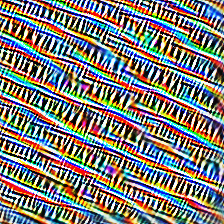

127.0.0.1 - - [09/Feb/2021 23:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:30] "POST /_dash-update-component HTTP/1.1" 204 -


Updating cached activations with 72-567_features_6_preadd_conv:3383_1612931799.4853816.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:37:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:37] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_edge_outmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
Updating cached rank dfs with overall
FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.413335   
1              1   features_0      0            0           1  1.875414   
2              2   features_0      0            0           2  0.506246   
3              3   features_0      0            1           0  0.555444   
4              4   features_0      0            1           1  1.380022   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.158831   
250044    250044  features_10      4          255         252  0.087745   
250045    250045  features_10      4          255         253  0.039325   
250046    250046  features_10      4          255         254  0.049232   
250047    

127.0.0.1 - - [09/Feb/2021 23:37:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:41] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:37:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:37:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:38:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 72_features_3:8_1607612700.370876.jpg
running model to fetch activations


127.0.0.1 - - [09/Feb/2021 23:38:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:38:47] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [09/Feb/2021 23:38:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:49] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:38:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:38:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:38:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 0
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-244
changing selected edge to 37-244
['g-21', '21-75', '75-306', '72-567', '37-244']


127.0.0.1 - - [09/Feb/2021 23:39:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
CALLED: update_edge_kernelmap
found pre-generated image


127.0.0.1 - - [09/Feb/2021 23:39:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0']
updating edge highlight to 37-244
updating node highlight to 0


127.0.0.1 - - [09/Feb/2021 23:39:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:39:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:05] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0


127.0.0.1 - - [09/Feb/2021 23:39:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:06] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image
CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 37
CALLED: update_node_inputs
CALLED: update_store
found pre-generated image

TRIGGER node-actmap-dropdown.value
37-244
changing selected node to 37


127.0.0.1 - - [09/Feb/2021 23:39:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37']
updating edge highlight to 37-244
updating node highlight to 37
0 0 features_0
generating feature_viz objective string for g-37


127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
generating feature_viz objective string for r-37
found pre-generated edge image
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 37_features_0:37_1607612533.3165665.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:39:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:44] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
CALLED: update_inputimg_actmap
generating feature_viz objective string for r-37
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:48] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [09/Feb/2021 23:39:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:39:54] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_node_actmap


127.0.0.1 - - [09/Feb/2021 23:40:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:40:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 37-244_features_3_preadd_conv:7284_1607613371.1676998.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:40:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
generating feature_viz objective string for r-37
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:40:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:41:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:40] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [09/Feb/2021 23:41:40] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached activations with curve_single_bw_tr_line.jpg
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:41:47] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_edge_inmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
update ranksdf_store triggered
Updating cached rank dfs with c
update ranksdf_store triggered
Updating cached rank dfs with cu
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-p

127.0.0.1 - - [09/Feb/2021 23:41:49] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [09/Feb/2021 23:41:49] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [09/Feb/2021 23:41:49] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
update ranksdf_store triggered
Updating cached rank dfs with curv
Updating cached rank dfs with cur


127.0.0.1 - - [09/Feb/2021 23:41:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:49] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.d

127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 500 -


generating feature_viz objective string for r-37
found pre-generated edge image
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/

127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggeredupdate ranksdf_store triggered

Updating cached rank dfs with curveUpdating cached rank dfs with curve_

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File 

127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:41:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with curve_s
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packag

127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_si
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packa

127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_sin
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pack

127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_sing
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pac

127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_singl
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pa

127.0.0.1 - - [09/Feb/2021 23:41:51] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-p

127.0.0.1 - - [09/Feb/2021 23:41:52] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-

127.0.0.1 - - [09/Feb/2021 23:41:53] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_b
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site

127.0.0.1 - - [09/Feb/2021 23:41:54] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/sit

127.0.0.1 - - [09/Feb/2021 23:41:55] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/si

127.0.0.1 - - [09/Feb/2021 23:41:56] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_t
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/s

127.0.0.1 - - [09/Feb/2021 23:41:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/

127.0.0.1 - - [09/Feb/2021 23:41:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6

127.0.0.1 - - [09/Feb/2021 23:41:58] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_l
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.

127.0.0.1 - - [09/Feb/2021 23:41:58] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_li
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3

127.0.0.1 - - [09/Feb/2021 23:41:59] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_lin
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python

127.0.0.1 - - [09/Feb/2021 23:41:59] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_line
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/pytho

127.0.0.1 - - [09/Feb/2021 23:41:59] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_line.
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/pyth

127.0.0.1 - - [09/Feb/2021 23:42:00] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_line.j
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/pyt

127.0.0.1 - - [09/Feb/2021 23:42:01] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_line.jp
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/py

127.0.0.1 - - [09/Feb/2021 23:42:01] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr_line.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr_line.jpg


127.0.0.1 - - [09/Feb/2021 23:42:07] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.508195   
1              1   features_0      0            0           1  0.566040   
2              2   features_0      0            0           2  0.705312   
3              3   features_0      0            1           0  1.195881   
4              4   features_0      0            1           1  2.890212   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.041631   
250045    250045  features_10      4          255         253  0.084109   
250046    250046  features_10      4          255         254  0.007011   
250047    250047  features_10      4          255         255  0.001432   

        grad_rank  actxgrad_rank  
0        0.000034       0.000080  
1        

127.0.0.1 - - [09/Feb/2021 23:42:07] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
generating feature_viz objective string for r-37
found pre-generated edge image
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.028245   
1              1   features_0      0            0           1  0.031574   
2              2   features_0      0            0           2  0.039589   
3              3   features_0      0            1           0  0.067819   
4              4   features_0      0            1           1  0.165321   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.022604   
250045    250045  features_10      4          255         253  0.0456

127.0.0.1 - - [09/Feb/2021 23:42:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37']
building graph from browser "state"


127.0.0.1 - - [09/Feb/2021 23:42:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [09/Feb/2021 23:42:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmapCALLED: update_node_actmap

CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
CALLED: update_edge_outmap
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-244
changing selected node to 53
found pre-generated image
CALLED: update_node_deepviz
generating feature_viz objective string for 53
found pre-generated image


127.0.0.1 - - [09/Feb/2021 23:42:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [09/Feb/2021 23:42:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
previous edge, 72-567,  not recolored as no longer shown
updating node highlight to 53
0 37 features_0


127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
generating feature_viz objective string for b-53


127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:21] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated edge image
generating feature_viz objective string for r-53
found pre-generated edge image
generating feature_viz objective string for g-53
found pre-generated edge image


127.0.0.1 - - [09/Feb/2021 23:42:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:33] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [09/Feb/2021 23:42:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
CALLED: update_node_actmap
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-244
changing selected node to 51
CALLED: update_edge_outmap
found pre-generated image
Updating cached activations with curve_single_bw_tr_line.jpg
running model to fetch activations
Updating cached activations with curve_single_bw_tr_line.jpg
running model to fetch activations
Updating cached activations with curve_single_bw_tr_line.jpg
running model to fetch activations
CALLED: update_node_deepviz
generating feature_viz objective string for 51
found pre-generated image


127.0.0.1 - - [09/Feb/2021 23:42:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
Updating cached activations with curve_single_bw_tr_line.jpg
running model to fetch activations


127.0.0.1 - - [09/Feb/2021 23:42:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:42:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
previous edge, 72-567,  not recolored as no longer shown
updating node highlight to 51
0 53 features_0


127.0.0.1 - - [09/Feb/2021 23:43:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:43:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:43:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:43:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:43:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2021 23:43:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [09/Feb/2021 23:43:20] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with curve_single_bw_tr_line.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr_line.jpg
FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.508195   
1              1   features_0      0            0           1  0.566040   
2              2   features_0      0            0           2  0.705312   
3              3   features_0      0            1           0  1.195881   
4              4   features_0      0            1           1  2.890212   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.041631   
250045    250045  features_10      4          255         253  0.08410

127.0.0.1 - - [09/Feb/2021 23:43:26] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-51
found pre-generated edge image
generating feature_viz objective string for b-51
found pre-generated edge image
generating feature_viz objective string for r-51
found pre-generated edge image
update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr.jpg


127.0.0.1 - - [10/Feb/2021 00:27:47] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.543868   
1              1   features_0      0            0           1  0.601545   
2              2   features_0      0            0           2  0.692045   
3              3   features_0      0            1           0  1.199262   
4              4   features_0      0            1           1  2.882852   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.045905   
250045    250045  features_10      4          255         253  0.093025   
250046    250046  features_10      4          255         254  0.011772   
250047    250047  features_10      4          255         255  0.003573   

        grad_rank  actxgrad_rank  
0        0.000037       0.000096  
1        

127.0.0.1 - - [10/Feb/2021 00:27:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:27:54] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51']
building graph from browser "state"


127.0.0.1 - - [10/Feb/2021 00:27:56] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-51
found pre-generated edge image
generating feature_viz objective string for b-51
found pre-generated edge image
generating feature_viz objective string for r-51
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:27:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:27:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:27:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:27:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:27:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with curve_single_bw_tr.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:28:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:28:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [10/Feb/2021 00:28:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
generating feature_viz objective string for g-51
found pre-generated edge image
generating feature_viz objective string for b-51
found pre-generated edge image
CALLED: update_edge_outmap
generating feature_viz objective string for r-51
CALLED: update_edge_inmap
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:28:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [10/Feb/2021 00:28:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_node_actmapCALLED: update_node_inputs

CALLED: update_node_deepviz
generating feature_viz objective string for 72


127.0.0.1 - - [10/Feb/2021 00:28:27] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-244
changing selected node to 72


127.0.0.1 - - [10/Feb/2021 00:28:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:28:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
found pre-generated image
CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:28:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:30] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 10-72
no deepviz for edge 10-72 for node inputs, looking for image for node 10
generating feature_viz objective string for 10
found pregenerated node image
generating feature_viz objective string for 57-72
no deepviz for edge 57-72 for node inputs, looking for image for node 57
generating feature_viz objective string for 57
found pregenerated node image
generating feature_viz objective string for 48-72
no deepviz for edge 48-72 for node inputs, looking for image for node 48
generating feature_viz objective string for 48
found pregenerated node image
generating feature_viz objective string for 3-72
found pre-generated edge image
generating feature_viz objective string for 39-72
no deepviz for edge 39-72 for node inputs, looking for image for node 39
generating feature_viz objective string for 39
found pregenerated node image
generating feature_viz objective string for 45-72
no deepviz for edge 45-72 for node inputs, looking for image for node 

127.0.0.1 - - [10/Feb/2021 00:28:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51', '72']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
updating node highlight to 72
0 51 features_0


127.0.0.1 - - [10/Feb/2021 00:28:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: switch_node_actmap_click


127.0.0.1 - - [10/Feb/2021 00:28:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_node_deepviz
generating feature_viz objective string for 65
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:28:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:47] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 12-65
no deepviz for edge 12-65 for node inputs, looking for image for node 12
generating feature_viz objective string for 12
found pregenerated node image
CALLED: update_edge_inmap
CALLED: update_edge_outmap
generating feature_viz objective string for 18-65
no deepviz for edge 18-65 for node inputs, looking for image for node 18
generating feature_viz objective string for 18
found pregenerated node image
generating feature_viz objective string for 34-65
no deepviz for edge 34-65 for node inputs, looking for image for node 34
generating feature_viz objective string for 34
found pregenerated node image
generating feature_viz objective string for 50-65
no deepviz for edge 50-65 for node inputs, looking for image for node 50
generating feature_viz objective string for 50
found pregenerated node image
generating feature_viz objective string for 16-65
no deepviz for edge 16-65 for node inputs, looking for image for node 16
generating feature_viz o

127.0.0.1 - - [10/Feb/2021 00:28:48] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
CALLED: update_edge_kernelmap
found pre-generated image
generating feature_viz objective string for 28-65
no deepviz for edge 28-65 for node inputs, looking for image for node 28
generating feature_viz objective string for 28
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:28:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:49] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 23-65
no deepviz for edge 23-65 for node inputs, looking for image for node 23
generating feature_viz objective string for 23
found pregenerated node image
generating feature_viz objective string for 47-65
no deepviz for edge 47-65 for node inputs, looking for image for node 47
generating feature_viz objective string for 47
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:28:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:28:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:28:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51', '72', '65']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
updating node highlight to 65
1 8 features_3


127.0.0.1 - - [10/Feb/2021 00:29:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:11] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_deepviz
generating feature_viz objective string for 37-244
CALLED: update_edge_kernelmap
CALLED: update_edge_outmap
CALLED: update_node_actmap
CALLED: update_edge_inmap
found pre-generated image
CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-244
changing selected node to 459


127.0.0.1 - - [10/Feb/2021 00:29:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
generating feature_viz objective string for 459
CALLED: update_node_inputs
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:29:15] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 72-459
no deepviz for edge 72-459 for node inputs, looking for image for node 72
generating feature_viz objective string for 72
found pregenerated node image
generating feature_viz objective string for 209-459
no deepviz for edge 209-459 for node inputs, looking for image for node 209
generating feature_viz objective string for 209
found pregenerated node image
generating feature_viz objective string for 140-459
no deepviz for edge 140-459 for node inputs, looking for image for node 140
generating feature_viz objective string for 140
found pregenerated node image
generating feature_viz objective string for 168-459
no deepviz for edge 168-459 for node inputs, looking for image for node 168
generating feature_viz objective string for 168
found pregenerated node image
generating feature_viz objective string for 91-459
no deepviz for edge 91-459 for node inputs, looking for image for node 91
generating feature_viz objective string for 91
found pr

127.0.0.1 - - [10/Feb/2021 00:29:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:16] "POST /_dash-update-component HTTP/1.1" 200 -


found pregenerated node image
generating feature_viz objective string for 152-459
no deepviz for edge 152-459 for node inputs, looking for image for node 152
generating feature_viz objective string for 152
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:29:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:29:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51', '72', '65', '459']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
updating node highlight to 459
1 1 features_3


127.0.0.1 - - [10/Feb/2021 00:29:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 152
CALLED: update_node_inputs
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:29:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-244
changing selected node to 152


127.0.0.1 - - [10/Feb/2021 00:29:53] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 50-152
no deepviz for edge 50-152 for node inputs, looking for image for node 50
generating feature_viz objective string for 50
found pregenerated node image
generating feature_viz objective string for 16-152
no deepviz for edge 16-152 for node inputs, looking for image for node 16
generating feature_viz objective string for 16
found pregenerated node image
generating feature_viz objective string for 10-152
no deepviz for edge 10-152 for node inputs, looking for image for node 10
generating feature_viz objective string for 10
found pregenerated node image
generating feature_viz objective string for 57-152
no deepviz for edge 57-152 for node inputs, looking for image for node 57
generating feature_viz objective string for 57
found pregenerated node image
generating feature_viz objective string for 34-152
no deepviz for edge 34-152 for node inputs, looking for image for node 34
generating feature_viz objective string for 34
found pregenerated n

127.0.0.1 - - [10/Feb/2021 00:29:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:29:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244']
['0', '37', '53', '51', '72', '65', '459', '152']
updating edge highlight to 37-244
select edge, 37-244,  not recolored as no longer shown
updating node highlight to 152
2 203 features_6
CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:30:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 152_features_3:88_1607613096.3106685.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:30:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:31:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [10/Feb/2021 00:31:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
generating feature_viz objective string for 50-152
no deepviz for edge 50-152 for node inputs, looking for image for node 50
generating feature_viz objective string for 50
found pregenerated node image
generating feature_viz objective string for 16-152
no deepviz for edge 16-152 for node inputs, looking for image for node 16
generating feature_viz objective string for 16
found pregenerated node image
generating feature_viz objective string for 10-152
no deepviz for edge 10-152 for node inputs, looking for image for node 10
generating feature_viz objective string for 10
found pregenerated node image
generating feature_viz objective string for 57-152
no deepviz for edge 57-152 for node inputs, looking for image for node 57
generating feature_viz objective string for 57
found pregenerated node image
generating feature_viz objective string for 34-152
no deepviz for edge 34-152 for node inputs, looking for image for node 34
generating feature_viz objective string 

127.0.0.1 - - [10/Feb/2021 00:31:09] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmapCALLED: update_edge_outmap



127.0.0.1 - - [10/Feb/2021 00:31:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_node_actmap


127.0.0.1 - - [10/Feb/2021 00:31:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_node_actmap


127.0.0.1 - - [10/Feb/2021 00:31:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:31:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
CALLED: update_edge_deepvizCALLED: update_edge_kernelmap

generating feature_viz objective string for 1
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File 

127.0.0.1 - - [10/Feb/2021 00:32:16] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:32:16] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
1
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File

127.0.0.1 - - [10/Feb/2021 00:32:16] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:32:16] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:32:16] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
12
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/ap

127.0.0.1 - - [10/Feb/2021 00:32:17] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 12
CALLED: update_edge_kernelmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/ho

127.0.0.1 - - [10/Feb/2021 00:32:18] "POST /_dash-update-component HTTP/1.1" 500 -


found pre-generated image
CALLED: update_edge_outmap
CALLED: update_edge_inmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/s

127.0.0.1 - - [10/Feb/2021 00:32:18] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:32:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
12-
edge inmap errorException on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-

127.0.0.1 - - [10/Feb/2021 00:32:19] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:32:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:32:19] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 12-
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/

127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
12-1
invalid edge name
CALLED: update_edge_deepviz
generating feature_viz objective string for 12-1
invalid edge name
invalid edge name
edge inmap error
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruni

127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:32:20] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error


127.0.0.1 - - [10/Feb/2021 00:32:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:32:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
12-15
invalid edge name
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:32:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:22] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge nameinvalid edge name
edge inmap error

edge outmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 12-15
invalid edge name
CALLED: update_edge_kernelmap
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.p

127.0.0.1 - - [10/Feb/2021 00:32:22] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
12-152
changing selected edge to 12-152
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152']


127.0.0.1 - - [10/Feb/2021 00:32:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 12-152
CALLED: update_edge_inmapCALLED: update_edge_kernelmap

CALLED: update_edge_outmap
deepviz image not found, generating . . .


127.0.0.1 - - [10/Feb/2021 00:32:23] "POST /_dash-update-component HTTP/1.1" 200 -
 10%|█         | 52/512 [00:02<00:19, 23.98it/s]127.0.0.1 - - [10/Feb/2021 00:32:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:32:26] "POST /_dash-update-component HTTP/1.1" 200 -
 11%|█         | 55/512 [00:02<00:20, 22.45it/s]

CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152']
['0', '37', '53', '51', '72', '65', '459', '152']
updating edge highlight to 12-152
select edge, 12-152,  not recolored as no longer shown
previous edge, 37-244,  not recolored as no longer shown
updating node highlight to 152
2 203 features_6


100%|██████████| 512/512 [00:21<00:00, 23.42it/s]



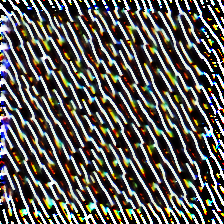

127.0.0.1 - - [10/Feb/2021 00:32:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
Updating cached activations with 152_features_3:88_1607613096.3106685.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:33:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepvizCALLED: update_node_inputs

generating feature_viz objective string for 12
Updating cached activations with 152_features_3:88_1607613096.3106685.jpg
found pre-generated image
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:33:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
12-152
changing selected node to 12


127.0.0.1 - - [10/Feb/2021 00:33:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152']
['0', '37', '53', '51', '72', '65', '459', '152', '12']
updating edge highlight to 12-152
select edge, 12-152,  not recolored as no longer shown
previous edge, 37-244,  not recolored as no longer shown
updating node highlight to 12
1 88 features_3


127.0.0.1 - - [10/Feb/2021 00:33:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:33:16] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with curve_single_bw_tr.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr.jpg


127.0.0.1 - - [10/Feb/2021 00:33:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.543868   
1              1   features_0      0            0           1  0.601545   
2              2   features_0      0            0           2  0.692045   
3              3   features_0      0            1           0  1.199262   
4              4   features_0      0            1           1  2.882852   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.045905   
250045    250045  features_10      4          255         253  0.093025   
250046    250046  features_10      4          255         254  0.011772   
250047    250047  features_10      4          255         255  0.003573   

        grad_rank  actxgrad_rank  
0        0.00

127.0.0.1 - - [10/Feb/2021 00:33:22] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for b-12
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:34:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:22] "POST /_dash-update-component HTTP/1.1" 204 -


Updating cached activations with 12-152_features_3_preadd_conv:2392_1612935143.0380626.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:34:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:34:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:34:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:33] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-12
found pre-generated edge image
generating feature_viz objective string for r-12
found pre-generated edge image
generating feature_viz objective string for b-12
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:34:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:34:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:35:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
24
y_click
32
Receptive field size for layer features_0, unit_position (24, 32),  is 
 [(94.0, 105.0), (126.0, 137.0)]
normalized
[[4.196428571428571, 4.6875], [5.625, 6.116071428571429]]
x points
[4.196428571428571, 4.196428571428571, 4.6875, 4.6875, 4.196428571428571]
y points
[4.375, 3.883928571428571, 3.883928571428571, 4.375, 4.375]


127.0.0.1 - - [10/Feb/2021 00:35:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
29
y_click
41
Receptive field size for layer features_0, unit_position (29, 41),  is 
 [(114.0, 125.0), (162.0, 173.0)]
normalized
[[5.089285714285714, 5.580357142857143], [7.232142857142857, 7.723214285714286]]
x points
[5.089285714285714, 5.089285714285714, 5.580357142857143, 5.580357142857143, 5.089285714285714]
y points
[2.7678571428571432, 2.2767857142857144, 2.2767857142857144, 2.7678571428571432, 2.7678571428571432]


127.0.0.1 - - [10/Feb/2021 00:35:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:35:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 12_features_0:12_1612824942.101911.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:36:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:36:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:36:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:23] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-12
found pre-generated edge image
generating feature_viz objective string for r-12
found pre-generated edge image
generating feature_viz objective string for b-12
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:36:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:27] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached activations with 12_features_0:12_1607612410.6522317.jpg
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:36:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
29
y_click
41
Receptive field size for layer features_0, unit_position (29, 41),  is 
 [(114.0, 125.0), (162.0, 173.0)]
normalized
[[5.089285714285714, 5.580357142857143], [7.232142857142857, 7.723214285714286]]
x points
[5.089285714285714, 5.089285714285714, 5.580357142857143, 5.580357142857143, 5.089285714285714]
y points
[2.7678571428571432, 2.2767857142857144, 2.2767857142857144, 2.7678571428571432, 2.7678571428571432]


127.0.0.1 - - [10/Feb/2021 00:36:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:36:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:36:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:37] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
29
y_click
41
Receptive field size for layer features_0, unit_position (29, 41),  is 
 [(114.0, 125.0), (162.0, 173.0)]
normalized
[[5.089285714285714, 5.580357142857143], [7.232142857142857, 7.723214285714286]]
x points
[5.089285714285714, 5.089285714285714, 5.580357142857143, 5.580357142857143, 5.089285714285714]
y points
[2.7678571428571432, 2.2767857142857144, 2.2767857142857144, 2.7678571428571432, 2.7678571428571432]


127.0.0.1 - - [10/Feb/2021 00:36:37] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-12
found pre-generated edge image
generating feature_viz objective string for r-12
found pre-generated edge image
generating feature_viz objective string for b-12
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:36:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:36:38] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmapCALLED: update_node_deepviz
generating feature_viz objective string for 152

CALLED: update_node_inputs
Updating cached activations with 12_features_0:12_1607612410.6522317.jpgUpdating cached activations with 12_features_0:12_1607612410.6522317.jpg

found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:38:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:38:07] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
12-152
changing selected node to 152
running model to fetch activations
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:38:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152']
['0', '37', '53', '51', '72', '65', '459', '152', '12', '152']
updating edge highlight to 12-152
select edge, 12-152,  not recolored as no longer shown
previous edge, 37-244,  not recolored as no longer shown
updating node highlight to 152
0 12 features_0


127.0.0.1 - - [10/Feb/2021 00:38:22] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with curve_single_bw_tr.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr.jpg


127.0.0.1 - - [10/Feb/2021 00:38:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
29
y_click
13
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py"

127.0.0.1 - - [10/Feb/2021 00:38:22] "POST /_dash-update-component HTTP/1.1" 500 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.543868   
1              1   features_0      0            0           1  0.601545   
2              2   features_0      0            0           2  0.692045   
3              3   features_0      0            1           0  1.199262   
4              4   features_0      0            1           1  2.882852   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.045905   
250045    250045  features_10      4          255         253  0.093025   
250046    250046  features_10      4          255         254  0.011772   
250047    250047  features_10      4          255         255  0.003573   

        grad_rank  actxgrad_rank  
0        0.000037       0.000096  
1        

127.0.0.1 - - [10/Feb/2021 00:38:28] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with curve_single_bw_tr.jpg
running model to get ranks for image: /mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images//curve_single_bw_tr.jpg
target reached, breaking model forward pass in features_3
88
tensor(-0.6765, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass


127.0.0.1 - - [10/Feb/2021 00:38:36] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.543868   
1              1   features_0      0            0           1  0.601545   
2              2   features_0      0            0           2  0.692045   
3              3   features_0      0            1           0  1.199262   
4              4   features_0      0            1           1  2.882852   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000007       0.000017  
1        

127.0.0.1 - - [10/Feb/2021 00:38:38] "POST /_dash-update-component HTTP/1.1" 200 -


no deepviz for edge 16-152 for node inputs, looking for image for node 16
generating feature_viz objective string for 16
found pregenerated node image
generating feature_viz objective string for 51-152
no deepviz for edge 51-152 for node inputs, looking for image for node 51
generating feature_viz objective string for 51
found pregenerated node image
generating feature_viz objective string for 10-152
no deepviz for edge 10-152 for node inputs, looking for image for node 10
generating feature_viz objective string for 10
found pregenerated node image
generating feature_viz objective string for 57-152
no deepviz for edge 57-152 for node inputs, looking for image for node 57
generating feature_viz objective string for 57
found pregenerated node image
generating feature_viz objective string for 48-152
no deepviz for edge 48-152 for node inputs, looking for image for node 48
generating feature_viz objective string for 48
found pregenerated node image
generating feature_viz objective string f

127.0.0.1 - - [10/Feb/2021 00:38:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:38:38] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 47-152
no deepviz for edge 47-152 for node inputs, looking for image for node 47
generating feature_viz objective string for 47
found pregenerated node image
update ranksdf_store triggered
Updating cached rank dfs with s
update ranksdf_store triggered
Updating cached rank dfs with sm
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, 

127.0.0.1 - - [10/Feb/2021 00:38:57] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:38:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with sma
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/f

127.0.0.1 - - [10/Feb/2021 00:38:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with smal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/

127.0.0.1 - - [10/Feb/2021 00:38:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages

127.0.0.1 - - [10/Feb/2021 00:38:57] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-package

127.0.0.1 - - [10/Feb/2021 00:38:58] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_S
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packag

127.0.0.1 - - [10/Feb/2021 00:38:58] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SP
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packa

127.0.0.1 - - [10/Feb/2021 00:38:59] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SPA
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pack

127.0.0.1 - - [10/Feb/2021 00:38:59] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for small_SPAN
batch 0
target reached, breaking model forward pass in features_3
88
tensor(-3.8006, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
88
tensor(-3.7554, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
88
tensor(-5.2908, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
88
tensor(-4.6984, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
88
tensor(-5.2470, device='cuda:0', grad_fn=<SelectBackward>)
target node 152 reached, halted forward pass


127.0.0.1 - - [10/Feb/2021 00:39:05] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.524794   
1              1   features_0      0            0           1  2.026979   
2              2   features_0      0            0           2  0.522660   
3              3   features_0      0            1           0  0.574127   
4              4   features_0      0            1           1  1.435901   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000004       0.000010  
1        

127.0.0.1 - - [10/Feb/2021 00:39:07] "POST /_dash-update-component HTTP/1.1" 200 -


no deepviz for edge 41-152 for node inputs, looking for image for node 41
generating feature_viz objective string for 41
found pregenerated node image
generating feature_viz objective string for 14-152
no deepviz for edge 14-152 for node inputs, looking for image for node 14
generating feature_viz objective string for 14
found pregenerated node image
generating feature_viz objective string for 32-152
no deepviz for edge 32-152 for node inputs, looking for image for node 32
generating feature_viz objective string for 32
found pregenerated node image
generating feature_viz objective string for 55-152
no deepviz for edge 55-152 for node inputs, looking for image for node 55
generating feature_viz objective string for 55
found pregenerated node image
generating feature_viz objective string for 17-152
no deepviz for edge 17-152 for node inputs, looking for image for node 17
generating feature_viz objective string for 17
found pregenerated node image
generating feature_viz objective string f

127.0.0.1 - - [10/Feb/2021 00:39:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:39:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152']
['0', '37', '53', '51', '72', '65', '459', '152', '12', '152']
building graph from browser "state"
CALLED: update_edge_kernelmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 1
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/

127.0.0.1 - - [10/Feb/2021 00:40:20] "POST /_dash-update-component HTTP/1.1" 500 -


found pre-generated image
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
1
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File

127.0.0.1 - - [10/Feb/2021 00:40:20] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
13
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/ap

127.0.0.1 - - [10/Feb/2021 00:40:20] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_inmap

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -



Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.vie

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_deepvizCALLED: update_edge_outmap

generating feature_viz objective string for 13
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/prun

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_kernelmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatc

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
13-


127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -


edge inmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 13-
CALLED: update_edge_kernelmap
CALLED: update_edge_outmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_re

127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:40:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
13-1
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap errorCALLED: update_edge_outmap



127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepvizCALLED: update_edge_kernelmap
invalid edge name

generating feature_viz objective string for 13-1
invalid edge name
CALLED: update_store

TRIGGER edge-actmaps-input.value
13-15
invalid edge name
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/

127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
invalid edge name
edge outmap error


127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
invalid edge name
edge inmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 13-15
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dis

127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_kernelmap
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
13-152
changing selected edge to 13-152
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152', '13-152']


127.0.0.1 - - [10/Feb/2021 00:40:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
invalid edge name
edge outmap error
CALLED: update_edge_outmap
CALLED: update_edge_kernelmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 13-152
CALLED: update_figure

[0.7, 1]
['g-21', '21-75', '75-306', '72-567', '37-244', '12-152', '13-152']
deepviz image not found, generating . . .
['0', '37', '53', '51', '72', '65', '459', '152', '12', '152']
updating edge highlight to 13-152
previous edge, 12-152,  not recolored as no longer shown
updating node highlight to 152
0 12 features_0


127.0.0.1 - - [10/Feb/2021 00:40:23] "POST /_dash-update-component HTTP/1.1" 200 -
  0%|          | 1/512 [00:00<00:56,  8.98it/s]127.0.0.1 - - [10/Feb/2021 00:40:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:23] "POST /_dash-update-component HTTP/1.1" 200 -
  2%|▏         | 8/512 [00:00<00:45, 11.07it/s]127.0.0.1 - - [10/Feb/2021 00:40:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:40:24] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:20<00:00, 24.38it/s]



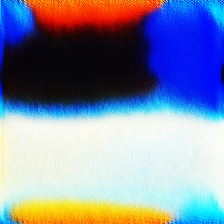

127.0.0.1 - - [10/Feb/2021 00:40:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:15] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:16] "POST /_dash-update-component HTTP/1.1" 204 -


Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
update ranksdf_store triggered
Updating cached rank dfs with overall


127.0.0.1 - - [10/Feb/2021 00:41:17] "GET /_dash-component-suites/dash_core_components/async-plotlyjs.v1_10_2m1595872686.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:18] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.413335   
1              1   features_0      0            0           1  1.875414   
2              2   features_0      0            0           2  0.506246   
3              3   features_0      0            1           0  0.555444   
4              4   features_0      0            1           1  1.380022   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.158831   
250044    250044  features_10      4          255         252  0.087745   
250045    250045  features_10      4          255         253  0.039325   
250046    250046  features_10      4          255         254  0.049232   
250047    250047  features_10      4          255         255  0.015319   

        grad_rank  actxgrad_rank  
0        0.000012   2.950812e-05  
1        

127.0.0.1 - - [10/Feb/2021 00:41:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_inmap
CALLED: update_edge_outmapCALLED: update_edge_deepvizCALLED: update_node_actmap

CALLED: update_edge_kernelmap

generating feature_viz objective string for g-21
found pre-generated image
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21


127.0.0.1 - - [10/Feb/2021 00:41:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image
CALLED: update_node_inputs

127.0.0.1 - - [10/Feb/2021 00:41:36] "POST /_dash-update-component HTTP/1.1" 200 -


127.0.0.1 - - [10/Feb/2021 00:41:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:38] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:41:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:47] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
updating edge highlight to g-21
updating node highlight to 0


127.0.0.1 - - [10/Feb/2021 00:41:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:41:54] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:41:59] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseballoverall
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/c

127.0.0.1 - - [10/Feb/2021 00:44:28] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball=overall
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/

127.0.0.1 - - [10/Feb/2021 00:44:29] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseballoverall
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/c

127.0.0.1 - - [10/Feb/2021 00:44:30] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-overall


127.0.0.1 - - [10/Feb/2021 00:44:32] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  5.601195   
1              1   features_0      0            0           1  7.351632   
2              2   features_0      0            0           2  1.894721   
3              3   features_0      0            1           0  2.347217   
4              4   features_0      0            1           1  5.549723   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.754628   
250044    250044  features_10      4          255         252  0.351051   
250045    250045  features_10      4          255         253  0.196414   
250046    250046  features_10      4          255         254  0.211379   
250047    250047  features_10      4          255         255  0.088733   

        grad_rank  actxgrad_rank  
0        0.000035   9.357055e-05  
1        

127.0.0.1 - - [10/Feb/2021 00:44:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:44:33] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [10/Feb/2021 00:44:40] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:45:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:45:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_node_deepviz
generating feature_viz objective string for 909
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:45:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21
changing selected node to 909
CALLED: update_edge_outmap
CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21


127.0.0.1 - - [10/Feb/2021 00:45:29] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:45:30] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:45:31] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '909']
updating edge highlight to g-21
updating node highlight to 909
0 0 features_0


127.0.0.1 - - [10/Feb/2021 00:45:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:45:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:45:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:45:31] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:45:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:45:32] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 693-909
no deepviz for edge 693-909 for node inputs, looking for image for node 693
generating feature_viz objective string for 693
found pregenerated node image
generating feature_viz objective string for 802-909
no deepviz for edge 802-909 for node inputs, looking for image for node 802
generating feature_viz objective string for 802
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:45:32] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 659-909
no deepviz for edge 659-909 for node inputs, looking for image for node 659
generating feature_viz objective string for 659
found pregenerated node image
generating feature_viz objective string for 657-909
no deepviz for edge 657-909 for node inputs, looking for image for node 657
generating feature_viz objective string for 657
found pregenerated node image
generating feature_viz objective string for 676-909
no deepviz for edge 676-909 for node inputs, looking for image for node 676
generating feature_viz objective string for 676
found pregenerated node image
generating feature_viz objective string for 825-909
no deepviz for edge 825-909 for node inputs, looking for image for node 825
generating feature_viz objective string for 825
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:45:32] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 851-909
no deepviz for edge 851-909 for node inputs, looking for image for node 851
generating feature_viz objective string for 851
found pregenerated node image
generating feature_viz objective string for 664-909
no deepviz for edge 664-909 for node inputs, looking for image for node 664
generating feature_viz objective string for 664
found pregenerated node image
generating feature_viz objective string for 742-909
no deepviz for edge 742-909 for node inputs, looking for image for node 742
generating feature_viz objective string for 742
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:45:33] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 785-909
no deepviz for edge 785-909 for node inputs, looking for image for node 785
generating feature_viz objective string for 785
found pregenerated node image
update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-overal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 

127.0.0.1 - - [10/Feb/2021 00:47:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-overa
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/ch

127.0.0.1 - - [10/Feb/2021 00:47:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-over
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chr

127.0.0.1 - - [10/Feb/2021 00:47:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-ove
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chri

127.0.0.1 - - [10/Feb/2021 00:47:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-ov
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris

127.0.0.1 - - [10/Feb/2021 00:47:35] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-o
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/

127.0.0.1 - - [10/Feb/2021 00:47:35] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/core/sympify.py", line 406, in sympify
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 1008, in parse_expr
    return eval_expr(code, local_dict, global_dict)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 903, in eval_expr
    code, global_dict, local_dict)  # take local objects in preference
  File "<string>", line 1
    Symbol ('x0' )+Symbol ('x1' )+Symbol ('x2' )+Symbol ('x3' )+Symbol ('x4' )-
                                                                              ^
SyntaxErro

127.0.0.1 - - [10/Feb/2021 00:47:35] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5
update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*


127.0.0.1 - - [10/Feb/2021 00:47:38] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
update ranksdf_store triggered        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  2.014530   
1              1   features_0      0            0           1  4.227046   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.000000   
4              4   features_0      0            1           1  1.929745   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0             

127.0.0.1 - - [10/Feb/2021 00:47:38] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/core/sympify.py", line 406, in sympify
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 1003, in parse_expr
    code = stringify_expr(s, local_dict, global_dict, transformations)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 887, in stringify_expr
    for toknum, tokval, _, _, _ in generate_tokens(input_code.readline):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/tokenize.py", line 602, in _tokenize
    raise TokenError("EOF in multi-line statement", (lnum, 0))
tokenize.TokenError: ('EOF in multi-line statement', (2, 0))

During handling of the above exception, another exception occurred:

127.0.0.1 - - [10/Feb/2021 00:47:38] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:47:38] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*(
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/core/sympify.py", line 406, in sympify
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 1003, in parse_expr
    code = stringify_expr(s, local_dict, global_dict, transformations)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 887, in stringify_expr
    for toknum, tokval, _, _, _ in generate_tokens(input_code.readline):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/tokenize.py", line 602, in _tokenize
    raise TokenError("EOF in multi-line statement", (lnum, 0))
token

127.0.0.1 - - [10/Feb/2021 00:47:38] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/core/sympify.py", line 406, in sympify
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 1008, in parse_expr
    return eval_expr(code, local_dict, global_dict)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 903, in eval_expr
    code, global_dict, local_dict)  # take local objects in preference
  File "<string>", line 1
    Symbol ('x0' )+Symbol ('x1' )+Symbol ('x2' )+Symbol ('x3' )+Symbol ('x4' )-Integer (5 )*
                                                                           

127.0.0.1 - - [10/Feb/2021 00:47:39] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*s
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chri

127.0.0.1 - - [10/Feb/2021 00:47:40] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*sm
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chr

127.0.0.1 - - [10/Feb/2021 00:47:40] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*sma
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/ch

127.0.0.1 - - [10/Feb/2021 00:47:40] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*smal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/c

127.0.0.1 - - [10/Feb/2021 00:47:40] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/

127.0.0.1 - - [10/Feb/2021 00:47:41] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home

127.0.0.1 - - [10/Feb/2021 00:47:41] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_S
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/hom

127.0.0.1 - - [10/Feb/2021 00:47:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SP
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/ho

127.0.0.1 - - [10/Feb/2021 00:47:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPA
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/h

127.0.0.1 - - [10/Feb/2021 00:47:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPAN


127.0.0.1 - - [10/Feb/2021 00:47:43] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.032026   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.020585   
250045    250045  features_10      4          255         253  0.061483   
250046    250046  features_10      4          255         254  0.042526   
250047    250047  features_10      4          255         255  0.031080   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [10/Feb/2021 00:47:45] "POST /_dash-update-component HTTP/1.1" 200 -


no deepviz for edge 851-909 for node inputs, looking for image for node 851
generating feature_viz objective string for 851
found pregenerated node image
generating feature_viz objective string for 742-909
no deepviz for edge 742-909 for node inputs, looking for image for node 742
generating feature_viz objective string for 742
found pregenerated node image
generating feature_viz objective string for 664-909
no deepviz for edge 664-909 for node inputs, looking for image for node 664
generating feature_viz objective string for 664
found pregenerated node image
generating feature_viz objective string for 785-909
no deepviz for edge 785-909 for node inputs, looking for image for node 785
generating feature_viz objective string for 785
found pregenerated node image
generating feature_viz objective string for 727-909
no deepviz for edge 727-909 for node inputs, looking for image for node 727
generating feature_viz objective string for 727
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:47:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:47:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '909']
building graph from browser "state"


127.0.0.1 - - [10/Feb/2021 00:48:12] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [10/Feb/2021 00:48:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
3
y_click
0
Receptive field size for layer features_10, unit_position (3, 0),  is 
 [(0, 145.0), (0, 97.0)]
normalized
[[0.0, 6.473214285714286], [0.0, 4.330357142857143]]
x points
[0.0, 0.0, 6.473214285714286, 6.473214285714286, 0.0]
y points
[10.0, 5.669642857142857, 5.669642857142857, 10.0, 10.0]


127.0.0.1 - - [10/Feb/2021 00:48:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
4
y_click
0
Receptive field size for layer features_10, unit_position (4, 0),  is 
 [(0, 161.0), (0, 97.0)]
normalized
[[0.0, 7.1875], [0.0, 4.330357142857143]]
x points
[0.0, 0.0, 7.1875, 7.1875, 0.0]
y points
[10.0, 5.669642857142857, 5.669642857142857, 10.0, 10.0]


127.0.0.1 - - [10/Feb/2021 00:48:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:28] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [10/Feb/2021 00:48:28] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached activations with baseball_10013.JPEG
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:48:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:48:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:38] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
4
y_click
0
Receptive field size for layer features_10, unit_position (4, 0),  is 
 [(0, 161.0), (0, 97.0)]
normalized
[[0.0, 7.1875], [0.0, 4.330357142857143]]
x points
[0.0, 0.0, 7.1875, 7.1875, 0.0]
y points
[10.0, 5.669642857142857, 5.669642857142857, 10.0, 10.0]
generating feature_viz objective string for 693-909
no deepviz for edge 693-909 for node inputs, looking for image for node 693
generating feature_viz objective string for 693
found pregenerated node image
generating feature_viz objective string for 802-909
no deepviz for edge 802-909 for node inputs, looking for image for node 802
generating feature_viz objective string for 802
found pregenerated node image
generating feature_viz objective string for 659-909
no deepviz for edge 659-909 for node inputs, looking for image for node 659
generating feature_viz objective string for 659
found pregenerated node image
generating feature_viz objective string for 657-909
no deepviz for edge 657

127.0.0.1 - - [10/Feb/2021 00:48:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:48:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 659
CALLED: update_node_inputs
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 659
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:49:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '909', '659']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 659
4 13 features_10


127.0.0.1 - - [10/Feb/2021 00:49:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:02] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 523-659
no deepviz for edge 523-659 for node inputs, looking for image for node 523
generating feature_viz objective string for 523
found pregenerated node image
generating feature_viz objective string for 560-659
no deepviz for edge 560-659 for node inputs, looking for image for node 560
generating feature_viz objective string for 560
found pregenerated node image
generating feature_viz objective string for 442-659
found pre-generated edge image
generating feature_viz objective string for 401-659
no deepviz for edge 401-659 for node inputs, looking for image for node 401
generating feature_viz objective string for 401
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:49:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:02] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 483-659
CALLED: update_inputimg_actmap
x_click
4
y_click
0
Receptive field size for layer features_8, unit_position (4, 0),  is 
 [(14.0, 145.0), (0, 81.0)]
normalized
[[0.625, 6.473214285714286], [0.0, 3.6160714285714284]]
x points
[0.625, 0.625, 6.473214285714286, 6.473214285714286, 0.625]
y points
[10.0, 6.383928571428571, 6.383928571428571, 10.0, 10.0]
no deepviz for edge 483-659 for node inputs, looking for image for node 483
generating feature_viz objective string for 483
found pregenerated node image
generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objectiv

127.0.0.1 - - [10/Feb/2021 00:49:02] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 630-659
no deepviz for edge 630-659 for node inputs, looking for image for node 630
generating feature_viz objective string for 630
found pregenerated node image
update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPAN


127.0.0.1 - - [10/Feb/2021 00:49:10] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.032026   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.020585   
250045    250045  features_10      4          255         253  0.061483   
250046    250046  features_10      4          255         254  0.042526   
250047    250047  features_10      4          255         255  0.031080   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [10/Feb/2021 00:49:11] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 483-659
no deepviz for edge 483-659 for node inputs, looking for image for node 483
generating feature_viz objective string for 483
found pregenerated node image
generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objective string for 418-659
no deepviz for edge 418-659 for node inputs, looking for image for node 418
generating feature_viz objective string for 418
found pregenerated node image
generating feature_viz objective string for 499-659
no deepviz for edge 499-659 for node inputs, looking for image for node 499
generating feature_viz objective string for 499


127.0.0.1 - - [10/Feb/2021 00:49:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_6_0m1596203731.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_6_0m1596203731.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_renderer/react@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.v1_10_2m1596203744.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:36] "GET /_dash-component-suites/dash_c

update ranksdf_store triggered
Updating cached rank dfs with overallUpdating cached activations with Afghan_hound_10.JPEG
running model to fetch activations



127.0.0.1 - - [10/Feb/2021 00:49:41] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.413335   
1              1   features_0      0            0           1  1.875414   
2              2   features_0      0            0           2  0.506246   
3              3   features_0      0            1           0  0.555444   
4              4   features_0      0            1           1  1.380022   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.158831   
250044    250044  features_10      4          255         252  0.087745   
250045    250045  features_10      4          255         253  0.039325   
250046    250046  features_10      4          255         254  0.049232   
250047    250047  features_10      4          255         255  0.015319   

        grad_rank  actxgrad_rank  
0        0.000012   2.950812e-05  
1        

127.0.0.1 - - [10/Feb/2021 00:49:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: switch_node_actmap_click


127.0.0.1 - - [10/Feb/2021 00:49:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
CALLED: update_node_actmap
CALLED: update_edge_kernelmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
found pre-generated image
CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:49:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:49:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [10/Feb/2021 00:50:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:00] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:50:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
updating edge highlight to g-21
updating node highlight to 0


127.0.0.1 - - [10/Feb/2021 00:50:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPAN


127.0.0.1 - - [10/Feb/2021 00:50:11] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.032026   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.020585   
250045    250045  features_10      4          255         253  0.061483   
250046    250046  features_10      4          255         254  0.042526   
250047    250047  features_10      4          255         255  0.031080   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [10/Feb/2021 00:50:12] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for r-0
found pre-generated edge image
maximum value 0 for rank type actxgrad and layer 0
generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image
maximum value 0 for rank type grad and layer 0
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.039464   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255

127.0.0.1 - - [10/Feb/2021 00:50:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"
CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 659
CALLED: update_node_inputs
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 659
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:50:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:32] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '659']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 659
0 0 features_0


127.0.0.1 - - [10/Feb/2021 00:50:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:33] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 523-659
no deepviz for edge 523-659 for node inputs, looking for image for node 523
generating feature_viz objective string for 523
found pregenerated node image
generating feature_viz objective string for 560-659
no deepviz for edge 560-659 for node inputs, looking for image for node 560
generating feature_viz objective string for 560
found pregenerated node image
CALLED: update_inputimg_actmap
generating feature_viz objective string for 442-659


127.0.0.1 - - [10/Feb/2021 00:50:33] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated edge image
generating feature_viz objective string for 401-659
no deepviz for edge 401-659 for node inputs, looking for image for node 401
generating feature_viz objective string for 401
found pregenerated node image
generating feature_viz objective string for 483-659
no deepviz for edge 483-659 for node inputs, looking for image for node 483
generating feature_viz objective string for 483
found pregenerated node image
generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objective string for 418-659
no deepviz for edge 418-659 for node inputs, looking for image for node 418
generating featur

127.0.0.1 - - [10/Feb/2021 00:50:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:41] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [10/Feb/2021 00:50:42] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached activations with baseball_10013.JPEG
running model to fetch activations
CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:50:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:50:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:50:52] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 523-659
no deepviz for edge 523-659 for node inputs, looking for image for node 523
generating feature_viz objective string for 523
found pregenerated node image
generating feature_viz objective string for 560-659
no deepviz for edge 560-659 for node inputs, looking for image for node 560
generating feature_viz objective string for 560
found pregenerated node image
generating feature_viz objective string for 442-659
found pre-generated edge image
generating feature_viz objective string for 401-659
no deepviz for edge 401-659 for node inputs, looking for image for node 401
generating feature_viz objective string for 401
found pregenerated node image
CALLED: update_inputimg_actmap
generating feature_viz objective string for 483-659


127.0.0.1 - - [10/Feb/2021 00:50:52] "POST /_dash-update-component HTTP/1.1" 200 -


no deepviz for edge 483-659 for node inputs, looking for image for node 483
generating feature_viz objective string for 483
found pregenerated node image
generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objective string for 418-659
no deepviz for edge 418-659 for node inputs, looking for image for node 418
generating feature_viz objective string for 418
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:50:52] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 499-659
no deepviz for edge 499-659 for node inputs, looking for image for node 499
generating feature_viz objective string for 499
found pregenerated node image
generating feature_viz objective string for 630-659
no deepviz for edge 630-659 for node inputs, looking for image for node 630
generating feature_viz objective string for 630
found pregenerated node image


127.0.0.1 - - [10/Feb/2021 00:50:53] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPAN


127.0.0.1 - - [10/Feb/2021 00:51:04] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.032026   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.020585   
250045    250045  features_10      4          255         253  0.061483   
250046    250046  features_10      4          255         254  0.042526   
250047    250047  features_10      4          255         255  0.031080   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [10/Feb/2021 00:51:05] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objective string for 418-659
no deepviz for edge 418-659 for node inputs, looking for image for node 418
generating feature_viz objective string for 418
found pregenerated node image
generating feature_viz objective string for 499-659
no deepviz for edge 499-659 for node inputs, looking for image for node 499
generating feature_viz objective string for 499
found pregenerated node image
generating feature_viz objective string for 630-659
no deepviz for edge 630-659 for node inputs, looking for image for node 630
generating feature_viz objective string for 630


127.0.0.1 - - [10/Feb/2021 00:51:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:51:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '659']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with tennis_ball+soccer_ball+ping_pong_ball+volleyball+baseball-5*small_SPAN


127.0.0.1 - - [10/Feb/2021 00:52:23] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.032026   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.020585   
250045    250045  features_10      4          255         253  0.061483   
250046    250046  features_10      4          255         254  0.042526   
250047    250047  features_10      4          255         255  0.031080   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [10/Feb/2021 00:52:24] "POST /_dash-update-component HTTP/1.1" 200 -


no deepviz for edge 483-659 for node inputs, looking for image for node 483
generating feature_viz objective string for 483
found pregenerated node image
generating feature_viz objective string for 446-659
no deepviz for edge 446-659 for node inputs, looking for image for node 446
generating feature_viz objective string for 446
found pregenerated node image
generating feature_viz objective string for 500-659
no deepviz for edge 500-659 for node inputs, looking for image for node 500
generating feature_viz objective string for 500
found pregenerated node image
generating feature_viz objective string for 418-659
no deepviz for edge 418-659 for node inputs, looking for image for node 418
generating feature_viz objective string for 418
found pregenerated node image
generating feature_viz objective string for 499-659
no deepviz for edge 499-659 for node inputs, looking for image for node 499
generating feature_viz objective string for 499
found pregenerated node image
generating feature_viz

127.0.0.1 - - [10/Feb/2021 00:52:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
CALLED: update_edge_kernelmap
CALLED: update_node_actmap
found pre-generated image
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 37


127.0.0.1 - - [10/Feb/2021 00:52:37] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_node_deepviz
generating feature_viz objective string for 37
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:52:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [10/Feb/2021 00:52:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '659', '37']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 37
3 19 features_8
CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for r-37
found pre-generated edge image
generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image


127.0.0.1 - - [10/Feb/2021 00:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
g-2
changing selected edge to g-2
['g-21', 'g-2']
CALLED: update_edge_deepviz
generating feature_viz objective string for g-2
CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:52:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
g-
CALLED: update_edge_inmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:52:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:54] "POST /_dash-update-component HTTP/1.1" 200 -


edge inmap error
CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:52:54] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for g-
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/l

127.0.0.1 - - [10/Feb/2021 00:52:54] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_figure

[0.7, 1]
['g-21']
['0', '659', '37']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 37
3 19 features_8
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-3
changing selected edge to g-3
['g-21', 'g-3']


127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for g-3
found pre-generated imageCALLED: update_edge_outmap

CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:52:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-37
changing selected edge to g-37
['g-21', 'g-37']
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:52:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for g-37
found pre-generated image


127.0.0.1 - - [10/Feb/2021 00:52:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37']
['0', '659', '37']
updating edge highlight to g-37
select edge, g-37,  not recolored as no longer shown
previous edge, g-21,  not recolored as no longer shown
updating node highlight to 37
3 19 features_8


127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:52:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
-37
CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
generating feature_viz objective string for -37
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = s

127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_outmap


127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap error
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-37
changing selected edge to r-37
['g-21', 'g-37', 'r-37']


127.0.0.1 - - [10/Feb/2021 00:53:04] "POST /_dash-update-component HTTP/1.1" 200 -


edge inmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for r-37
found pre-generated image
CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:53:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37']
['0', '659', '37']
updating edge highlight to r-37
select edge, r-37,  not recolored as no longer shown
previous edge, g-37,  not recolored as no longer shown
updating node highlight to 37
3 19 features_8
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:53:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
-37
CALLED: update_edge_deepviz
generating feature_viz objective string for -37
CALLED: update_edge_kernelmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = s

127.0.0.1 - - [10/Feb/2021 00:53:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:10] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:53:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:11] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap error
CALLED: update_store

TRIGGER edge-actmaps-input.value
b-37
changing selected edge to b-37
['g-21', 'g-37', 'r-37', 'b-37']
CALLED: update_edge_deepviz
generating feature_viz objective string for b-37
CALLED: update_edge_outmap
found pre-generated image
edge inmap error


127.0.0.1 - - [10/Feb/2021 00:53:11] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:53:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:11] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37']
['0', '659', '37']
updating edge highlight to b-37
select edge, b-37,  not recolored as no longer shown
previous edge, r-37,  not recolored as no longer shown
updating node highlight to 37
3 19 features_8


127.0.0.1 - - [10/Feb/2021 00:53:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:33] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
CALLED: update_node_inputs
CALLED: update_store

TRIGGER target-signal.children
maximum value 0 for rank type grad and layer 0
generating feature_viz objective string for r-37


127.0.0.1 - - [10/Feb/2021 00:53:34] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated edge image
generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
maximum value 0 for rank type actxgrad and layer 0
maximum value 0 for rank type grad and layer 0
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.000000   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.039464   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.011362   
250045    250045  fe

127.0.0.1 - - [10/Feb/2021 00:53:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37']
['0', '659', '37']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with small_SPAN


127.0.0.1 - - [10/Feb/2021 00:53:52] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.524794   
1              1   features_0      0            0           1  2.026979   
2              2   features_0      0            0           2  0.522660   
3              3   features_0      0            1           0  0.574127   
4              4   features_0      0            1           1  1.435901   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.204984   
250044    250044  features_10      4          255         252  0.083642   
250045    250045  features_10      4          255         253  0.034851   
250046    250046  features_10      4          255         254  0.043617   
250047    250047  features_10      4          255         255  0.014594   

        grad_rank  actxgrad_rank  
0        0.000013   3.396565e-05  
1        

127.0.0.1 - - [10/Feb/2021 00:53:53] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
generating feature_viz objective string for r-37
found pre-generated edge image
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.185796   
1              1   features_0      0            0           1  0.250709   
2              2   features_0      0            0           2  0.056259   
3              3   features_0      0            1           0  0.062912   
4              4   features_0      0            1           1  0.174306   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.323380   
250044    250044  features_10      4          255         252  0.128858   
250045    250045  features_10      4          255         253  0.0506

127.0.0.1 - - [10/Feb/2021 00:53:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:53:54] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37']
['0', '659', '37']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for small_SPAN
batch 0
target reached, breaking model forward pass in features_8
19
tensor(-5.1593, device='cuda:0', grad_fn=<SelectBackward>)
target node 659 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
19
tensor(-4.2450, device='cuda:0', grad_fn=<SelectBackward>)
target node 659 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
19
tensor(-5.0247, device='cuda:0', grad_fn=<SelectBackward>)
target node 659 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
19
tensor(-4.3235, device='cuda:0', grad_fn=<SelectBackward>)
target node 659 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_8
19
tenso

127.0.0.1 - - [10/Feb/2021 00:54:07] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.524794   
1              1   features_0      0            0           1  2.026979   
2              2   features_0      0            0           2  0.522660   
3              3   features_0      0            1           0  0.574127   
4              4   features_0      0            1           1  1.435901   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000016       0.000039  
1        

127.0.0.1 - - [10/Feb/2021 00:54:08] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-37
maximum value 0 for rank type grad and layer 4
found pre-generated edge image
generating feature_viz objective string for b-37
found pre-generated edge image
generating feature_viz objective string for r-37
found pre-generated edge image
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.185796   
1              1   features_0      0            0           1  0.250709   
2              2   features_0      0            0           2  0.056259   
3              3   features_0      0            1           0  0.062912   
4              4   features_0      0            1           1  0.174306   
...          ...          ...    ...          ...   

127.0.0.1 - - [10/Feb/2021 00:54:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37']
['0', '659', '37']
building graph from browser "state"


127.0.0.1 - - [10/Feb/2021 00:54:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:54:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 659
CALLED: update_store

TRIGGER node-actmap-dropdown.value
b-37
changing selected node to 659
found pre-generated image
CALLED: update_node_inputs


127.0.0.1 - - [10/Feb/2021 00:54:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:54:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:54:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37']
['0', '659', '37', '659']
updating edge highlight to b-37
select edge, b-37,  not recolored as no longer shown
previous edge, r-37,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


127.0.0.1 - - [10/Feb/2021 00:54:18] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 278-659
no deepviz for edge 278-659 for node inputs, looking for image for node 278
generating feature_viz objective string for 278
found pregenerated node image
generating feature_viz objective string for 429-659
no deepviz for edge 429-659 for node inputs, looking for image for node 429
generating feature_viz objective string for 429
found pregenerated node image
generating feature_viz objective string for 283-659
no deepviz for edge 283-659 for node inputs, looking for image for node 283
generating feature_viz objective string for 283
found pregenerated node image
generating feature_viz objective string for 487-659
no deepviz for edge 487-659 for node inputs, looking for image for node 487
generating feature_viz objective string for 487
found pregenerated node image
CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:54:18] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 533-659
no deepviz for edge 533-659 for node inputs, looking for image for node 533
generating feature_viz objective string for 533
found pregenerated node image
generating feature_viz objective string for 539-659
no deepviz for edge 539-659 for node inputs, looking for image for node 539
generating feature_viz objective string for 539
found pregenerated node image
generating feature_viz objective string for 356-659
no deepviz for edge 356-659 for node inputs, looking for image for node 356
generating feature_viz objective string for 356
found pregenerated node image
generating feature_viz objective string for 300-659
no deepviz for edge 300-659 for node inputs, looking for image for node 300
generating feature_viz objective string for 300
found pregenerated node image
generating feature_viz objective string for 454-659
no deepviz for edge 454-659 for node inputs, looking for image for node 454
generating feature_viz objective string for 454


127.0.0.1 - - [10/Feb/2021 00:54:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
Updating cached activations with baseball_10013.JPEG
running model to fetch activations


127.0.0.1 - - [10/Feb/2021 00:54:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:54:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:54:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [10/Feb/2021 00:54:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
8
y_click
3
Receptive field size for layer features_8, unit_position (8, 3),  is 
 [(78.0, 209.0), (0, 129.0)]
normalized
[[3.482142857142857, 9.330357142857142], [0.0, 5.758928571428571]]
x points
[3.482142857142857, 3.482142857142857, 9.330357142857142, 9.330357142857142, 3.482142857142857]
y points
[10.0, 4.241071428571429, 4.241071428571429, 10.0, 10.0]


127.0.0.1 - - [10/Feb/2021 00:55:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
3
y_click
3
Receptive field size for layer features_8, unit_position (3, 3),  is 
 [(0, 129.0), (0, 129.0)]
normalized
[[0.0, 5.758928571428571], [0.0, 5.758928571428571]]
x points
[0.0, 0.0, 5.758928571428571, 5.758928571428571, 0.0]
y points
[10.0, 4.241071428571429, 4.241071428571429, 10.0, 10.0]
CALLED: update_store

TRIGGER edge-actmaps-input.value
4
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/

127.0.0.1 - - [10/Feb/2021 00:55:38] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_deepvizCALLED: update_edge_kernelmap

generating feature_viz objective string for 4
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pr

127.0.0.1 - - [10/Feb/2021 00:55:38] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_outmap
found pre-generated image
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
44
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  Fil

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_r

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_deepviz
generating feature_viz objective string for 44
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_kernelmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatc

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
446
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/a

127.0.0.1 - - [10/Feb/2021 00:55:39] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_kernelmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 446
CALLED: update_edge_inmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/h

127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
446-
CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 446-
CALLED: update_edge_outmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3

127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_edge_kernelmap
edge inmap error
edge outmap error


127.0.0.1 - - [10/Feb/2021 00:55:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
446-6
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
invalid edge name
CALLED: update_edge_deepviz
generating feature_viz objective string for 446-6
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request(

127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
446-65
invalid edge name
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 446-65
invalid edge name
invalid edge nameCALLED: update_edge_outmap
CALLED: update_edge_kernelmap
invalid edge name

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/li

127.0.0.1 - - [10/Feb/2021 00:55:41] "POST /_dash-update-component HTTP/1.1" 500 -



invalid edge name
edge inmap error


127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
446-659
changing selected edge to 446-659
['g-21', 'g-37', 'r-37', 'b-37', '446-659']


127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 446-659
CALLED: update_edge_outmap
deepviz image not found, generating . . .
CALLED: update_edge_inmap
CALLED: update_edge_kernelmap


  0%|          | 0/512 [00:00<?, ?it/s]127.0.0.1 - - [10/Feb/2021 00:55:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659']
['0', '659', '37', '659']
updating edge highlight to 446-659
select edge, 446-659,  not recolored as no longer shown
previous edge, b-37,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


  1%|          | 5/512 [00:00<01:31,  5.57it/s]127.0.0.1 - - [10/Feb/2021 00:55:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:55:43] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:28<00:00, 17.77it/s]



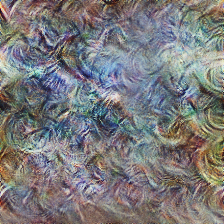

127.0.0.1 - - [10/Feb/2021 00:56:11] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
44-659
invalid edge name
CALLED: update_edge_kernelmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 44-659
invalid edge name
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:21] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
invalid edge name
edge inmap error
CALLED: update_store

TRIGGER edge-actmaps-input.value
4-659
invalid edge name
CALLED: update_edge_deepviz
generating feature_viz objective string for 4-659
invalid edge name
CALLED: update_edge_inmap
CALLED: update_edge_outmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  F

127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
invalid edge name
CALLED: update_store

TRIGGER edge-actmaps-input.value
45-659
invalid edge name
CALLED: update_edge_inmap


127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
invalid edge name
edge inmap error
CALLED: update_edge_outmapCALLED: update_edge_deepviz
generating feature_viz objective string for 45-659
invalid edge name
CALLED: update_edge_kernelmap
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.

127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 500 -


127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge nameinvalid edge name
edge outmap error

edge inmap error
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
454-659
changing selected edge to 454-659
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659']
CALLED: update_edge_deepviz
generating feature_viz objective string for 454-659


127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:22] "POST /_dash-update-component HTTP/1.1" 200 -
  0%|          | 0/512 [00:00<?, ?it/s]

deepviz image not found, generating . . .


127.0.0.1 - - [10/Feb/2021 00:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
  0%|          | 1/512 [00:00<04:39,  1.83it/s]

CALLED: update_edge_kernelmap
CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659']
['0', '659', '37', '659']
updating edge highlight to 454-659
select edge, 454-659,  not recolored as no longer shown
previous edge, 446-659,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


  1%|          | 4/512 [00:01<02:27,  3.45it/s]127.0.0.1 - - [10/Feb/2021 00:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:29<00:00, 17.20it/s]



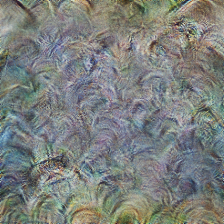

127.0.0.1 - - [10/Feb/2021 00:56:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_kernelmapCALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 2-659
invalid edge name

invalid edge name
CALLED: update_store

TRIGGER edge-actmaps-input.value
2-659
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/minico

127.0.0.1 - - [10/Feb/2021 00:57:03] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge inmap error
invalid edge name
edge outmap error
CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659']
['0', '659', '37', '659']
updating edge highlight to 454-659
select edge, 454-659,  not recolored as no longer shown
previous edge, 446-659,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmapCALLED: update_edge_deepvizCALLED: update_edge_inmap


generating feature_viz objective string for 28-659
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_re

127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
28-659
invalid edge name
CALLED: update_edge_kernelmap
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:57:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
283-659
changing selected edge to 283-659
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659', '283-659']
CALLED: update_edge_inmap
CALLED: update_edge_outmap
invalid edge name
edge outmap error
invalid edge name
edge inmap error
CALLED: update_edge_deepviz
generating feature_viz objective string for 283-659
CALLED: update_edge_kernelmap
deepviz image not found, generating . . .
CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659', '283-659']
['0', '659', '37', '659']
updating edge highlight to 283-659
previous edge, 454-659,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -
  0%|          | 0/512 [00:00<?, ?it/s]127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:06] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:28<00:00, 18.16it/s]



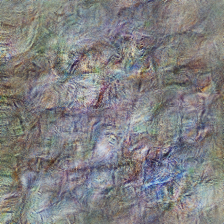

127.0.0.1 - - [10/Feb/2021 00:57:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
28-659
invalid edge name
CALLED: update_edge_deepviz
generating feature_viz objective string for 28-659
invalid edge name
CALLED: update_edge_kernelmap
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/mini

127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:38] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
invalid edge name
edge inmap error
CALLED: update_store

TRIGGER edge-actmaps-input.value
2-659
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_edge_kernelmap
invalid edge name
CALLED: update_edge_inmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 2-659
invalid edge name
invalid edge nameinvalid edge name
edge outmap error
edge inmap error

CALLED: update_store
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
   

127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -



TRIGGER edge-actmaps-input.value
-659


127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -


edge inmap error
CALLED: update_edge_outmap
CALLED: update_edge_deepviz
generating feature_viz objective string for -659
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/m

127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659', '283-659']
['0', '659', '37', '659']
updating edge highlight to 283-659
previous edge, 454-659,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


127.0.0.1 - - [10/Feb/2021 00:57:39] "POST /_dash-update-component HTTP/1.1" 200 -


edge outmap error


127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmapCALLED: update_edge_deepviz
generating feature_viz objective string for 3-659
invalid edge name

CALLED: update_edge_outmap
CALLED: update_edge_kernelmap
invalid edge name
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in 

127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
3-659
invalid edge name


127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
30-659
invalid edge name
invalid edge name
CALLED: update_edge_outmap
CALLED: update_edge_inmapCALLED: update_edge_deepviz
generating feature_viz objective string for 30-659
invalid edge name

edge outmap error
invalid edge name
edge inmap error
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
 

127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:40] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [10/Feb/2021 00:57:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:41] "POST /_dash-update-component HTTP/1.1" 200 -


invalid edge name
edge outmap error
invalid edge name
edge inmap error
CALLED: update_edge_kernelmap
invalid edge name
CALLED: update_edge_inmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
300-659
changing selected edge to 300-659
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659', '283-659', '300-659']
CALLED: update_edge_outmap
CALLED: update_edge_deepviz
generating feature_viz objective string for 300-659
CALLED: update_edge_kernelmap
deepviz image not found, generating . . .
CALLED: update_figure

[0.7, 1]
['g-21', 'g-37', 'r-37', 'b-37', '446-659', '454-659', '283-659', '300-659']
['0', '659', '37', '659']
updating edge highlight to 300-659
select edge, 300-659,  not recolored as no longer shown
updating node highlight to 659
0 37 features_0


127.0.0.1 - - [10/Feb/2021 00:57:41] "POST /_dash-update-component HTTP/1.1" 200 -
  1%|          | 3/512 [00:00<01:16,  6.68it/s]127.0.0.1 - - [10/Feb/2021 00:57:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 00:57:42] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:26<00:00, 19.03it/s]



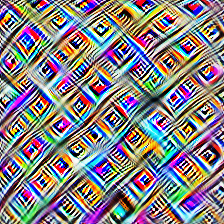

127.0.0.1 - - [10/Feb/2021 00:58:08] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
app.run_server(port=8051)

In [ ]:
def gen_node_inputs_graph(nodeid,image_name,target,rank_type,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations_store(image_name)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=1)
    #print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)

        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          showscale = False,
                          colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                                          y=(i)/len(top_node_edges_df)-.01,
                                          thicknessmode = "fraction",thickness=.1,
                                          ypad=1
                                         )),
               row=i, col=1)
        i+=1
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=170,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    return fig



def gen_node_inputs_graph_with_viz(nodeid,image_name,target,rank_type,model,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations_store(image_name)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=2)
    #print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)
        #add activation map
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          coloraxis="coloraxis"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=2),
        #add visualization
        viz_img_name = fetch_deepviz_img_for_node_inputs(model,edge_name,params)
        viz_img_path = params['prepped_model_path']+'/visualizations/images/'+viz_img_name
        viz_img = Image.open(viz_img_path)
        #fig.add_trace(go.Image(z=viz_img,name=viz_img_name), row=i, col=1)
        fig.add_trace(go.Scatter(x=[],y=[]),row=i,col=1)
        fig.add_layout_image(
                            source=viz_img,
                            xref="x",
                            yref="y",
                            x=0,
                            y=10,
                            sizex=10,
                            sizey=10,
                            sizing="stretch",
                            opacity=1,
                            layer="below",
                            row=i, col=1
                            )
        fig.update_xaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
        fig.update_yaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
   


        i+=1
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=340,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      #xaxis=dict(visible=False),
                      #yaxis=dict(visible=False),
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    fig.update_coloraxes(colorscale='inferno',colorbar = dict(
                                                              thicknessmode = "fraction",thickness=.05, 
                                                              lenmode='fraction',len=.7)
                        )
    return fig



def image2plot(image_path,layout,resize = False,size = (32,32)):
	img = Image.open(image_path)
	if resize:
		img = img.resize(size,resample=Image.NEAREST)

	trace1 = go.Scatter(x=[],y=[])
	fig=go.Figure(data=[trace1],layout=layout)
	fig.update_layout(images= [dict(
									source= img,
									xref= "x",
									yref= "y",
									x= 0,
									y= 10,
									sizex= 10,
									sizey= 10,
									sizing= "stretch",
									opacity= 1,
									layer= "below"
									)
								]
					 )
	return fig

#Edge deepviz graph
@app.callback(
    Output('edge-deepviz-image', 'figure'),
    [Input('edge-actmaps-input', 'value')])
def update_edge_deepviz(edgename):       #EDIT: needs support for black and white images
    print('CALLED: update_edge_deepviz')
    #layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    #if layer == 'img': 
    #    return figure_init
    image_name = fetch_deepviz_img(model_dis,edgename,params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)

'''
def gen_input_viz(act_fig):
    fig = make_subplots(rows=len(act_fig.data), cols=1)
    for i in range(len(act_fig.data)):
        nodeid = act_fig.data[i].name.split('-')[0]
        image_name = fetch_deepviz_img(model_dis,nodeid,params)
        image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
        img = Image.open(image_path)
        
               fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          showscale = False,
                          colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                                          y=(i)/len(top_node_edges_df)-.01,
                                          thicknessmode = "fraction",thickness=.1,
                                          ypad=1
                                         )),
               row=i, col=1)
        i+=1
        
'''        

# def fetch_deepviz_img_for_node_inputs(model,edgeid,params):
#     model = set_across_model(model,'target_node',None)
#     objective = gen_objective_str(edgeid,model,params)
#     file_path = params['prepped_model_path']+'/visualizations/images.csv'
#     parametrizer = params['deepviz_param']
#     optimizer = params['deepviz_optim']
#     transforms = params['deepviz_transforms']
#     image_size = params['deepviz_image_size']

#     param_str = object_2_str(parametrizer,"params['deepviz_param']=")
#     optimizer_str = object_2_str(optimizer,"params['deepviz_optim']=")
#     transforms_str = object_2_str(transforms,"params['deepviz_transforms']=")
#     df = pd.read_csv(file_path,dtype=str)
#     df_sel = df.loc[(df['targetid'] == str(edgeid)) & (df['objective'] == objective) & (df['parametrizer'] == param_str) & (df['optimizer'] == optimizer_str) & (df['transforms'] == transforms_str)]
#     if len(df_sel) == 0:
#         if 'r' in edgeid or 'g' in edgeid or 'b' in edgeid or 'gs' in edgeid:
#             print('deepviz image not found for node input %s, generating . . .'%edgeid)
#             #image_name = 'deepviz_'+str(targetid)+'_'+objective+'_'+str(time.time())+'.jpg'
#             image_name = str(edgeid)+'_'+objective+'_'+str(time.time())+'.jpg'
#             gen_visualization(model,image_name,objective,parametrizer,optimizer,transforms,image_size,params) 
#             with open(file_path, 'a') as csv:
#                 csv.write(','.join([image_name,str(edgeid),objective,param_str,optimizer_str,transforms_str])+'\n')
#         else:
#             nodeid = edgeid.split('-')[0]
#             print('no deepviz for edge %s for node inputs, looking for image for node %s'%(edgeid,nodeid))
#             objective = gen_objective_str(nodeid,model,params)
#             df_sel = df.loc[(df['targetid'] == str(nodeid)) & (df['objective'] == objective) & (df['parametrizer'] == param_str) & (df['optimizer'] == optimizer_str) & (df['transforms'] == transforms_str)]
#             if len(df_sel) == 0:
#                 print('STILL no deepviz image found! generating now, but you should pregenerate these!')
#                 image_name = str(nodeid)+'_'+objective+'_'+str(time.time())+'.jpg'
#                 gen_visualization(model,image_name,objective,parametrizer,optimizer,transforms,image_size,params) 
#             else:
#                 print('found pregenerated node image')
#                 image_name = df_sel.iloc[0]['image_name'] 
            
#     else:
#         print('found pre-generated edge image')
#         image_name = df_sel.iloc[0]['image_name']   
#     return image_name




fig1 = gen_node_inputs_graph_with_viz('100','tiger_0.JPEG',['tiger_0.JPEG','663'],'act',model_dis)

In [ ]:

#fig1.data[0].name.split('-')[0]
fig1

In [ ]:
# import plotly.express as px

# df = px.data.iris()
# fig = px.scatter(df, x="sepal_length", y="sepal_width", facet_col="species")
# # sources of images
# sources = [
#     "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Iris_setosa_var._setosa_%282595031014%29.jpg/360px-Iris_setosa_var._setosa_%282595031014%29.jpg",
#     "https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Iris_versicolor_quebec_1.jpg/320px-Iris_versicolor_quebec_1.jpg",
#     "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Iris_virginica_2.jpg/480px-Iris_virginica_2.jpg",
# ]
# # add images
# for col, src in enumerate(sources):
#     fig.add_layout_image(
#         row=1,
#         col=col + 1,
#         source=src,
#         xref="x domain",
#         yref="y domain",
#         x=1,
#         y=1,
#         xanchor="right",
#         yanchor="top",
#         sizex=0.2,
#         sizey=0.2,
#     )

# fig.show()

In [ ]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# #from skimage import io
# #img = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Crab_Nebula.jpg/240px-Crab_Nebula.jpg')
# image_path = params['prepped_model_path']+'/visualizations/images/'+'3_features_3_preadd_conv:593_1611455559.153431.jpg'
# img = Image.open(image_path)

# fig = make_subplots(
#     rows=1, cols=2)
# fig.add_trace(go.Image(z=img), 1, 1)
# fig.add_trace(go.Image(z=img), 1, 2)

In [ ]:
image_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/input_images/leatherback_turtle_10037.JPEG'
img = Image.open(image_path)
fig = go.Figure(data=go.Image(z=img,dx=300,dy=300))

In [ ]:
fig.show()

In [ ]:
preprocess = params['preprocess']
img_processed = preprocess(img).float()

img_processed

In [ ]:
preprocess_no_normalize = transforms.Compose([
        						transforms.Resize((224,224)),
        						transforms.ToTensor()])

img_no_normalize = preprocess_no_normalize(img).float()

img_no_normalize

back_img = transforms.ToPILImage(img_processed)
back_img

In [ ]:
img_processed[0].shape

In [ ]:
np.array(img)

In [ ]:
activations